In [8]:
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.preprocessing import Normalizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import AutoModel, AutoTokenizer, GPT2Config
import torch
import transformers
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
import datetime
from tqdm import tqdm
from sklearn.preprocessing import Normalizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import LogitsProcessor, LogitsProcessorList
import ast
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from time_stuff.utils import LinearMetricEmbedder
# template = """Answer the question based on the context below. Keep the answer short.

# Context: {context}
# Question: {question}
# Answer:"""

# template = """{context}
# {question}
# Answer:"""

# template = """Answer the question based on the context below. Keep the answer short.

# Context: {context}"""

template = """{context}"""

In [ ]:
class ConstrainedPrefixLogitsProcessor(LogitsProcessor):
    def __init__(self, allowed_seqs, tokenizer):
        self.tokenizer = tokenizer
        # Add a space at the start of each sequence
        self.allowed_seqs = [f" {seq}" for seq in allowed_seqs]
        # Add period to the allowed sequences
        self.allowed_seqs.append('.')
        self.allowed_seqs.append('<|end_of_text|>')

        self.allowed_token_seqs = [tokenizer(seq, add_special_tokens=False)['input_ids'] for seq in self.allowed_seqs]
        # Add end of sentence token to the allowed sequences
        self.allowed_token_seqs.append([tokenizer.eos_token_id])
         
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        batch_size, vocab_size = scores.shape
        current_len = input_ids.shape[-1]
        
        allowed_next_tokens = set()
        for seq in self.allowed_token_seqs:
            if len(seq) > current_len:
                if torch.equal(input_ids[0][-len(seq)+1:], torch.tensor(seq[:-1], device=input_ids.device)):
                    allowed_next_tokens.add(seq[len(input_ids[0]) - len(seq)])

        if not allowed_next_tokens:
            # Start of generation, allow first tokens of all candidate sequences
            allowed_next_tokens = {seq[0] for seq in self.allowed_token_seqs}

        mask = torch.full_like(scores, float("-inf"))
        for token_id in allowed_next_tokens:
            mask[0, token_id] = scores[0, token_id]
        return mask


def format_time(time):
    if time.hour == 0:
        return f"{time.strftime('%I:%M%p').lower()}"
    elif time.hour == 12:
        return f"{time.strftime('%I:%M%p').lower()}"
    else:
        if time.minute == 0:
            return f"{time.strftime('%-I%p').lower()}"
        else:
            return f"{time.strftime('%-I:%M%p').lower()}"

def clean(x):
    return ast.literal_eval(x)

def compute_activations(df, model, tokenizer, idx_column='date_idx_end', question_column='question', answer_column='correct', context_column='context', target_content=None):
    model.eval()
    outputs = []
    for _, row in tqdm(df.iterrows()):
        context = row[context_column] if context_column in row else row['sentence']
        question = row[question_column] if question_column in row else None
        answer = row[answer_column] if answer_column in row else None
        sentence = template.format(context=context, question=question, answer=answer)

        input_ids = tokenizer(sentence, return_tensors="pt").to("cuda")
        if target_content is not None:
            # Find the index of the target content in the sentence
            content = row[target_content] if target_content in row else None
            idx_end = sentence.find(content)
            if idx_end == -1:
                raise ValueError(f"Content '{content}' not found in the sentence.")
            idx_end = idx_end + len(content)
            idx_end = len(tokenizer(sentence[:idx_end])['input_ids']) - 1
            
        elif idx_column is not None:
            idx_end = row[idx_column]

            # idx_end might be shifted if the formatted context is later in the sentence
            # find the context in the sentence, compute the new idx_end
            idx_end = sentence.find(context) + idx_end

            idx_end = len(tokenizer(sentence[:idx_end])['input_ids']) - 1
        else:
            idx_end = -1

        hidden_states = model(**input_ids, output_hidden_states=True).hidden_states
        hidden_states = [h.type(torch.float16) for h in hidden_states]
        hidden_states = torch.concat(hidden_states, dim=0).cpu().detach().numpy()[:,idx_end,:]
        outputs.append(hidden_states)
    return np.stack(outputs, axis=1)

def eval_dataset(df, model, tokenizer, question_column='question', answer_column='correct', context_column='context'):
    model.eval()
    correct = []
    with tqdm(df.iterrows(), total=len(df)) as pbar:
        for _, row in pbar:
            context = row[context_column] if context_column in row else row['sentence']
            question = row[question_column] if question_column in row else None
            # answer = row[answer_column] if answer_column in row else None
            sentence = template.format(context=context, question=question, answer='')

            input_ids = tokenizer(sentence, return_tensors="pt").to("cuda")

            # Generate the answer to the question, no sampling
            outputs = model.generate(**input_ids, max_new_tokens=8)
            # Decode the generated answer. Keep only answer and not entire prompt
            answer = tokenizer.decode(outputs[0][len(input_ids['input_ids'][0]):], skip_special_tokens=True)
            # Check if the generated answer is correct
            if row[answer_column] in answer:
                correct.append(1)
            else:
                correct.append(0)
            # print(f"Running mean: {np.array(correct).mean()} Generation: {answer} Correct: {row[answer_column]}")
            # Display running mean in tqdm
            pbar.set_postfix({'Running mean': np.array(correct).mean()})

    return np.array(correct), np.array(correct).mean()

# Does both the evaluation and storing of activations
def activate_eval(df, model, tokenizer, question_column='question', answer_column='correct', context_column='context', 
                  target_column=None, bypass_eval=False, constrained_generation=False, delta_token=None):
    model.eval()
    outputs = []
    filtered_df = []
    logits_processor = None
        
    for _, row in tqdm(df.iterrows(), total=len(df)):
        context = row[context_column] if context_column in row else row['sentence']
        question = row[question_column] if question_column in row else None
        answer = str(row[answer_column]) if answer_column in row else None
        sentence = template.format(context=context, question=question, answer=answer)

        input_ids = tokenizer(sentence, return_tensors="pt").to("cuda")

        if constrained_generation:
            if 'alternatives' not in row:
                raise ValueError("Alternatives column not found in dataset.")
            logits_processor = LogitsProcessorList()
            logits_processor.append(ConstrainedPrefixLogitsProcessor(
                allowed_seqs=row['alternatives'],
                tokenizer=tokenizer
            ))

        # Generate the answer to the question, no sampling
        # NOTE: generate only outputs the hidden states of the generation, not the input
        generations = model.generate(**input_ids, max_new_tokens=8, return_dict_in_generate=True, output_hidden_states=True, 
                                     do_sample=False, logits_processor=logits_processor)
        # Decode the generated answer. Keep only answer and not entire prompt
        decoded = tokenizer.decode(generations.sequences[0][len(input_ids['input_ids'][0]):], skip_special_tokens=True)

        # Check if the generated answer is correct
        answer_idx = decoded.find(answer)
        if answer_idx == -1 and not bypass_eval:
            continue  

        if target_column is None:
            # generate() outputs a set of hidden states for each generated token
            # we first need to find the corresponding generation index in the generated text using answer_idx
            gen_idx = answer_idx + len(answer)
            gen_idx = len(tokenizer(decoded[:gen_idx])['input_ids']) - 1
            target_idx = len(input_ids['input_ids'][0]) - 1 + gen_idx
            if delta_token is not None: # Get a shifted token
                target_idx = target_idx + delta_token
        else: # Find the last token of the target content
            # Find the index of the target content in the sentence
            content = row[target_column] if target_column in row else None
            idx_end = sentence.find(content)
            if idx_end == -1:
                raise ValueError(f"Content '{content}' not found in the sentence.")
            idx_end = idx_end + len(content)
            idx_end = len(tokenizer(sentence[:idx_end])['input_ids'])
            target_idx = idx_end

        # NOTE: the first element of hidden_states is the input embedding, it has word size n_prompt_tokens
        # and the rest are the hidden states of the generated tokens each with size 1
        # We can stack them as (n_layers, tokens, hidden_dim)
        # the full length of tokens is = prompt size + n_generated_tokens - 1
        hidden_states = torch.cat([torch.cat(hs, dim=0) for hs in generations.hidden_states], dim=1)
        hidden_states = hidden_states.type(torch.float64)
        try:
            hidden_states = hidden_states[:, target_idx]
        except IndexError:
            print(f"IndexError: {gen_idx} out of range for {target_idx}")
            continue
        hidden_states = hidden_states.cpu().detach().numpy()

        # hidden_states = generations.hidden_states[gen_idx]
        # hidden_states = [h.type(torch.float16)[0,idx_end,:] for h in hidden_states]


        outputs.append(hidden_states)
        filtered_df.append(row)

IndentationError: unexpected indent (3484430945.py, line 44)

### Activations

Run one of the following cells to set which dataset to compute the activations on

In [ ]:
# Run model on absolute relative sentences (tagged for dates and verbs)

transformers.set_seed(42)

df = pd.read_csv('datasets/templates/absolute_ordered_sentences.csv')
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['datetime'] = pd.to_datetime(df['datetime'])
df['label'] = df['datetime'].apply(lambda x: x.timestamp())
# Dates go from 01-01-2019 to 31-12-2019
start = datetime.datetime(2019, 1, 1).timestamp()
end = datetime.datetime(2019, 12, 31).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))


# Create train and test sets
split = 0.8
train_set = df.iloc[:int(len(df)*split)]
dev_set = df.iloc[int(len(df)*split):]
test_set = df

activations_train = compute_activations(train_set, model=model, tokenizer=tokenizer, context_column='sentence')
activations_dev = compute_activations(dev_set, model=model, tokenizer=tokenizer, context_column='sentence')
activations_test = compute_activations(test_set, model=model, tokenizer=tokenizer, context_column='sentence')

labels_train = train_set['label']
labels_dev = dev_set['label']
labels_test = test_set['label']


0it [00:00, ?it/s]

752it [00:04, 170.21it/s]
188it [00:01, 172.65it/s]
940it [00:05, 169.28it/s]


In [ ]:
# Run model on relative relative sentences

transformers.set_seed(42)

df = pd.read_csv('datasets/templates/relative_ordered_sentences.csv')
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['label'] = df['hours_delta']
# Perform absolute value and log scaling
df['label'] = df['label'].apply(lambda x: np.log(np.abs(x)+1))
# Normalize min and max
min_hours = df['label'].min()
max_hours = df['label'].max()
df['label'] = df['label'].apply(lambda x: (x-min_hours)/(max_hours-min_hours))
# Print min and max to check if normalization is correct
# print(df['label'].min(), df['label'].max())

df['class'] = df['reference_type']

# Create train and test sets
split = 0.8
train_set = df.iloc[:int(len(df)*split)]
dev_set = df.iloc[int(len(df)*split):]
test_set = df

activations_train = compute_activations(train_set, model=model, tokenizer=tokenizer)
activations_dev = compute_activations(dev_set, model=model, tokenizer=tokenizer)
activations_test = compute_activations(test_set, model=model, tokenizer=tokenizer)

labels_train = train_set['label']
labels_dev = dev_set['label']
labels_test = test_set['label']

400it [00:18, 22.02it/s]
100it [00:04, 21.23it/s]
500it [00:22, 21.94it/s]


In [ ]:
# Run model on reasoning sentences

transformers.set_seed(42)

df = pd.read_csv('datasets/templates/reasoning_sentences.csv')
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['correct_date'] = pd.to_datetime(df['correct_date'])
df['label'] = df['correct_date'].apply(lambda x: x.timestamp())
# Dates go from 01-01-2019 to 31-12-2019
start = datetime.datetime(2019, 1, 1).timestamp()
end = datetime.datetime(2019, 12, 31).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))

# Create train and dev sets
split = 0.8
train_set = df.iloc[:int(len(df)*split)]
dev_set = df.iloc[int(len(df)*split):]

activations_train = compute_activations(train_set, model=model, tokenizer=tokenizer, idx_column=None, target_content='correct')
activations_dev = compute_activations(dev_set, model=model, tokenizer=tokenizer, idx_column=None, target_content='correct')
activations_test = compute_activations(df, model=model, tokenizer=tokenizer, idx_column=None, target_content='correct')

labels_train = train_set['label']
labels_dev = dev_set['label']
labels_test = df['label']

# activations_train_date = eval_df(train_set, idx_column='date_idx_end')
# activations_test_date = eval_df(test_set, idx_column='date_idx_end')
# activations_train_answer = eval_df(train_set, idx_column=None)
# activations_test_answer = eval_df(test_set, idx_column=None)


# activations_train = activations_train_date
# activations_test = activations_test_date

# all_activations = np.concatenate([activations_train_answer, activations_test_answer], axis=1)
# # all_activations = np.concatenate([activations_train, activations_test], axis=1)
# all_labels = df['label']

0it [00:00, ?it/s]

600it [00:03, 167.33it/s]
150it [00:00, 169.42it/s]
750it [00:04, 168.20it/s]


In [ ]:
# Run model on numerical reasoning sentences

transformers.set_seed(42)

df = pd.read_csv('datasets/templates/reasoning_sentences_num.csv')
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['correct_date'] = pd.to_datetime(df['correct_date'])
df['label'] = df['correct_date'].apply(lambda x: x.timestamp())
# Dates go from 01-01-2019 to 31-12-2019
start = datetime.datetime(2019, 1, 1).timestamp()
end = datetime.datetime(2019, 12, 31).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))
df['correct'] = df['correct'].astype(str)

# Create train and dev sets
split = 0.8
train_set = df.iloc[:int(len(df)*split)]
dev_set = df.iloc[int(len(df)*split):]
test_set = df

activations_train = compute_activations(train_set, model=model, tokenizer=tokenizer, idx_column='date_idx_end', question_column='question_num')
activations_dev = compute_activations(dev_set, model=model, tokenizer=tokenizer, idx_column='date_idx_end', question_column='question_num')
activations_test = compute_activations(test_set, model=model, tokenizer=tokenizer, idx_column=None, question_column='question_num')


labels_train = train_set['label']
labels_dev = dev_set['label']
labels_test = test_set['label']

600it [00:03, 167.43it/s]
150it [00:00, 168.91it/s]
750it [00:04, 171.49it/s]


In [ ]:
# Eval model performance on reasoning sentences

transformers.set_seed(42)

df = pd.read_csv('datasets/templates/reasoning_sentences.csv')
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['correct_date'] = pd.to_datetime(df['correct_date'])
df['label'] = df['correct_date'].apply(lambda x: x.timestamp())
# Dates go from 01-01-2019 to 31-12-2019
start = datetime.datetime(2019, 1, 1).timestamp()
end = datetime.datetime(2019, 12, 31).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))
df['correct'] = df['correct'].astype(str)

# Create train and dev sets
split = 0.8
test_set = df

generations, accuracy = eval_dataset(test_set, model=model, tokenizer=tokenizer, question_column='question')

print("Accuracy: ", accuracy)

In [ ]:
# Eval model performance on numerical reasoning sentences

transformers.set_seed(42)

df = pd.read_csv('datasets/templates/reasoning_sentences_num.csv')
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['correct_date'] = pd.to_datetime(df['correct_date'])
df['label'] = df['correct_date'].apply(lambda x: x.timestamp())
# Dates go from 01-01-2019 to 31-12-2019
start = datetime.datetime(2019, 1, 1).timestamp()
end = datetime.datetime(2019, 12, 31).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))
df['correct'] = df['correct'].astype(str)

# Create train and dev sets
split = 0.8
test_set = df

generations, accuracy = eval_dataset(test_set, model=model, tokenizer=tokenizer, question_column='question_num')

print("Accuracy: ", accuracy)

In [ ]:
# Eval/activate model on date reasoning sentences
transformers.set_seed(42)

df = pd.read_csv('datasets/templates/reasoning_sentences_3way_cyclic.csv',
                 converters={'alternatives': clean})
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['correct_date'] = pd.to_datetime(df['correct_date'])
df['label'] = df['correct_date'].apply(lambda x: x.timestamp())
# Dates go from 01-01-2019 to 31-12-2019
start = datetime.datetime(2019, 1, 1).timestamp()
end = datetime.datetime(2019, 12, 31).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))

# Create train and dev sets
split = 0.8
train_set = df.iloc[:int(len(df)*split)]
dev_set = df.iloc[int(len(df)*split):]

activations_train, train_set = activate_eval(train_set, model=model, tokenizer=tokenizer, constrained_generation=True) #, target_column='time_str')
activations_dev, dev_set = activate_eval(dev_set, model=model, tokenizer=tokenizer, constrained_generation=True) #, target_column='time_str')
# activations_test, test_set = activate_eval(df, model=model, tokenizer=tokenizer)
# Get test set by combining train and dev sets
activations_test = np.concatenate([activations_train, activations_dev], axis=1)
test_set = pd.concat([train_set, dev_set], axis=0)

labels_train = train_set['label']
labels_dev = dev_set['label']
labels_test = test_set['label']

In [ ]:
# Eval/activate model on duration reasoning sentences
transformers.set_seed(42)

df = pd.read_csv('datasets/templates/duration_reasoning_3way_1hop.csv',
                 converters={'alternatives': clean})
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['correct_date'] = pd.to_datetime(df['correct_date'])
df['label'] = df['correct_date'].apply(lambda x: x.timestamp())
# Dates go from 01-01-2019 to 31-12-2019
start = datetime.datetime(2019, 1, 1).timestamp()
end = datetime.datetime(2019, 12, 31).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))

# Create train and dev sets
split = 0.5
train_set = df.iloc[:int(len(df)*split)]
dev_set = df.iloc[int(len(df)*split):]

activations_train, train_set = activate_eval(train_set, model=model, tokenizer=tokenizer) #, bypass_eval=True, target_column='correct_date_expr')
activations_dev, dev_set = activate_eval(dev_set, model=model, tokenizer=tokenizer) #, bypass_eval=True, target_column='correct_date_expr')
# activations_test, test_set = activate_eval(df, model=model, tokenizer=tokenizer)
# Get test set by combining train and dev sets
# activations_test = np.concatenate([activations_train, activations_dev], axis=1)
# test_set = pd.concat([train_set, dev_set], axis=0)
activations_test = activations_dev
test_set = dev_set


labels_train = train_set['label']
labels_dev = dev_set['label']
labels_test = test_set['label']

  0%|          | 0/498 [00:00<?, ?it/s]/home/tiblias/miniconda3/envs/time-stuff/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/tiblias/miniconda3/envs/time-stuff/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
100%|██████████| 498/498 [01:37<00:00,  5.09it/s]


Model accuracy: 0.29116465863453816


  0%|          | 0/498 [00:00<?, ?it/s]/home/tiblias/miniconda3/envs/time-stuff/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/tiblias/miniconda3/envs/time-stuff/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
100%|██████████| 498/498 [01:37<00:00,  5.08it/s]


Model accuracy: 0.3032128514056225


In [ ]:
# Eval/activate model on time of day reasoning sentences
transformers.set_seed(42)

df = pd.read_csv('datasets/templates/reasoning_time_of_day_HH:MM.csv',
                 converters={'alternatives': clean})
# Shuffle the dataset
df = df.sample(frac=0.5)
# Take datetimes and normalize them to a 0-1 range
df['correct_time'] = pd.to_datetime(df['correct_time']).apply(lambda x: x.replace(year=2019, month=1, day=1))
df['label'] = df['correct_time'].apply(lambda x: x.timestamp())
# Dates go from 12am to 11:59pm
start = datetime.datetime(2019, 1, 1, hour=0, minute=0).timestamp()
end = datetime.datetime(2019, 1, 1, hour=23, minute=59).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))
print(df['label'].min(), df['label'].max())

# Create train and dev sets
split = 0.5
train_set = df.iloc[:int(len(df)*split)]
dev_set = df.iloc[int(len(df)*split):]

activations_train, train_set = activate_eval(train_set, model=model, tokenizer=tokenizer, delta_token=-1, bypass_eval=True)#, constrained_generation=True) #, target_column='time_str')
activations_dev, dev_set = activate_eval(dev_set, model=model, tokenizer=tokenizer, delta_token=-1, bypass_eval=True)#, constrained_generation=True) #, target_column='time_str')
# activations_test, test_set = activate_eval(df, model=model, tokenizer=tokenizer)
# Get test set by combining train and dev sets
activations_test = np.concatenate([activations_train, activations_dev], axis=1)
test_set = pd.concat([train_set, dev_set], axis=0)

labels_train = train_set['label']
labels_dev = dev_set['label']
labels_test = test_set['label']

0.04169562195969423 1.0319666435024322


  0%|          | 0/450 [00:00<?, ?it/s]/home/tiblias/miniconda3/envs/time-stuff/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/tiblias/miniconda3/envs/time-stuff/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.
100%|██████████| 450/450 [01:27<00:00,  5.15it/s]


Model accuracy: 1.0


  0%|          | 0/451 [00:00<?, ?it/s]/home/tiblias/miniconda3/envs/time-stuff/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/tiblias/miniconda3/envs/time-stuff/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
100%|██████████| 451/451 [01:26<00:00,  5.21it/s]


Model accuracy: 1.0


In [ ]:
# # Replace labels with something else
# df['label'] = df['correct_time_diff']
# min_label = df['label'].min()
# max_label = df['label'].max()
# df['label'] = df['label'].apply(lambda x: (x-min_label)/(max_label-min_label))

# # NB: this introduces data leakage
# labels_train = train_set['correct_time_diff'].apply(lambda x: (x-min_label)/(max_label-min_label))
# labels_dev = dev_set['correct_time_diff'].apply(lambda x: (x-min_label)/(max_label-min_label))
# labels_test = test_set['correct_time_diff'].apply(lambda x: (x-min_label)/(max_label-min_label))

# Map season labels to numbers 0: winter, 1: spring, 2: summer, 3: fall
# labels_train = train_set['correct_season'].apply(lambda x: 0 if x == 'winter' else (1 if x == 'spring' else (2 if x == 'summer' else 3))).to_numpy()
# labels_dev = dev_set['correct_season'].apply(lambda x: 0 if x == 'winter' else (1 if x == 'spring' else (2 if x == 'summer' else 3))).to_numpy()
# labels_test = test_set['correct_season'].apply(lambda x: 0 if x == 'winter' else (1 if x == 'spring' else (2 if x == 'summer' else 3))).to_numpy()

# Introduce secondary labels
# Finds the start and end of the time range
# secondary_start = pd.to_datetime(df['correct_date']).min().timestamp()
# secondary_end = pd.to_datetime(df['correct_end_date']).max().timestamp()
# secondary_labels_train = pd.to_datetime(train_set['correct_end_date']).apply(lambda x: x.timestamp()).apply(lambda x: x-secondary_start)
# secondary_labels_dev = pd.to_datetime(dev_set['correct_end_date']).apply(lambda x: x.timestamp()).apply(lambda x: x-secondary_start)
# secondary_labels_test = pd.to_datetime(test_set['correct_end_date']).apply(lambda x: x.timestamp()).apply(lambda x: x-secondary_start)

secondary_labels_train = train_set['correct_duration_days'].apply(lambda x: np.log(x))
secondary_labels_dev = dev_set['correct_duration_days'].apply(lambda x: np.log(x))
secondary_labels_test = test_set['correct_duration_days'].apply(lambda x: np.log(x))

joint_labels_train = pd.DataFrame({'label': labels_train, 'secondary_label': secondary_labels_train})
joint_labels_dev = pd.DataFrame({'label': labels_dev, 'secondary_label': secondary_labels_dev})
joint_labels_test = pd.DataFrame({'label': labels_test, 'secondary_label': secondary_labels_test})

# double_labels_test = (labels_test.copy() + secondary_labels_test.copy()) / 2

# df_time = pd.to_datetime(df['time'])
# # df_time = pd.to_datetime(df['correct_time'])
# df_time = df_time.apply(lambda x: x.replace(year=2019, month=1, day=1))
# df_time = df_time.apply(lambda x: x.timestamp())
# # Dates go from 12am to 11:59pm
# start = datetime.datetime(2019, 1, 1, hour=0, minute=0).timestamp()
# end = datetime.datetime(2019, 1, 1, hour=23, minute=59).timestamp()

# labels_train = pd.to_datetime(train_set['correct_time']).apply(lambda x: x.replace(year=2019, month=1, day=1)).apply(lambda x: x.timestamp()).apply(lambda x: (x-start)/(end-start))
# labels_dev = pd.to_datetime(dev_set['correct_time']).apply(lambda x: x.replace(year=2019, month=1, day=1)).apply(lambda x: x.timestamp()).apply(lambda x: (x-start)/(end-start))
# labels_test = pd.to_datetime(test_set['correct_time']).apply(lambda x: x.replace(year=2019, month=1, day=1)).apply(lambda x: x.timestamp()).apply(lambda x: (x-start)/(end-start))


### Plotting

Run one of the following cells to plot the activations

/home/tiblias/Projects/time-stuff/time_stuff/utils.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df[col] = metadata_df[col].apply(func)
1it [00:02,  2.21s/it]

Layer: 1 Score: 0.5402543477668784


2it [00:04,  2.03s/it]

Layer: 3 Score: 0.8023083264599493


3it [00:06,  2.27s/it]

Layer: 7 Score: 0.8519109241354863


4it [00:08,  2.10s/it]

Layer: 10 Score: 0.8908862732401481


5it [00:10,  2.23s/it]

Layer: 14 Score: 0.8822932808160245


6it [00:12,  2.09s/it]

Layer: 18 Score: 0.8705725781996464


7it [00:15,  2.13s/it]

Layer: 21 Score: 0.8739403240618083


8it [00:17,  2.21s/it]

Layer: 25 Score: 0.8606224981957348


9it [00:19,  2.21s/it]

Layer: 28 Score: 0.8473344805372134


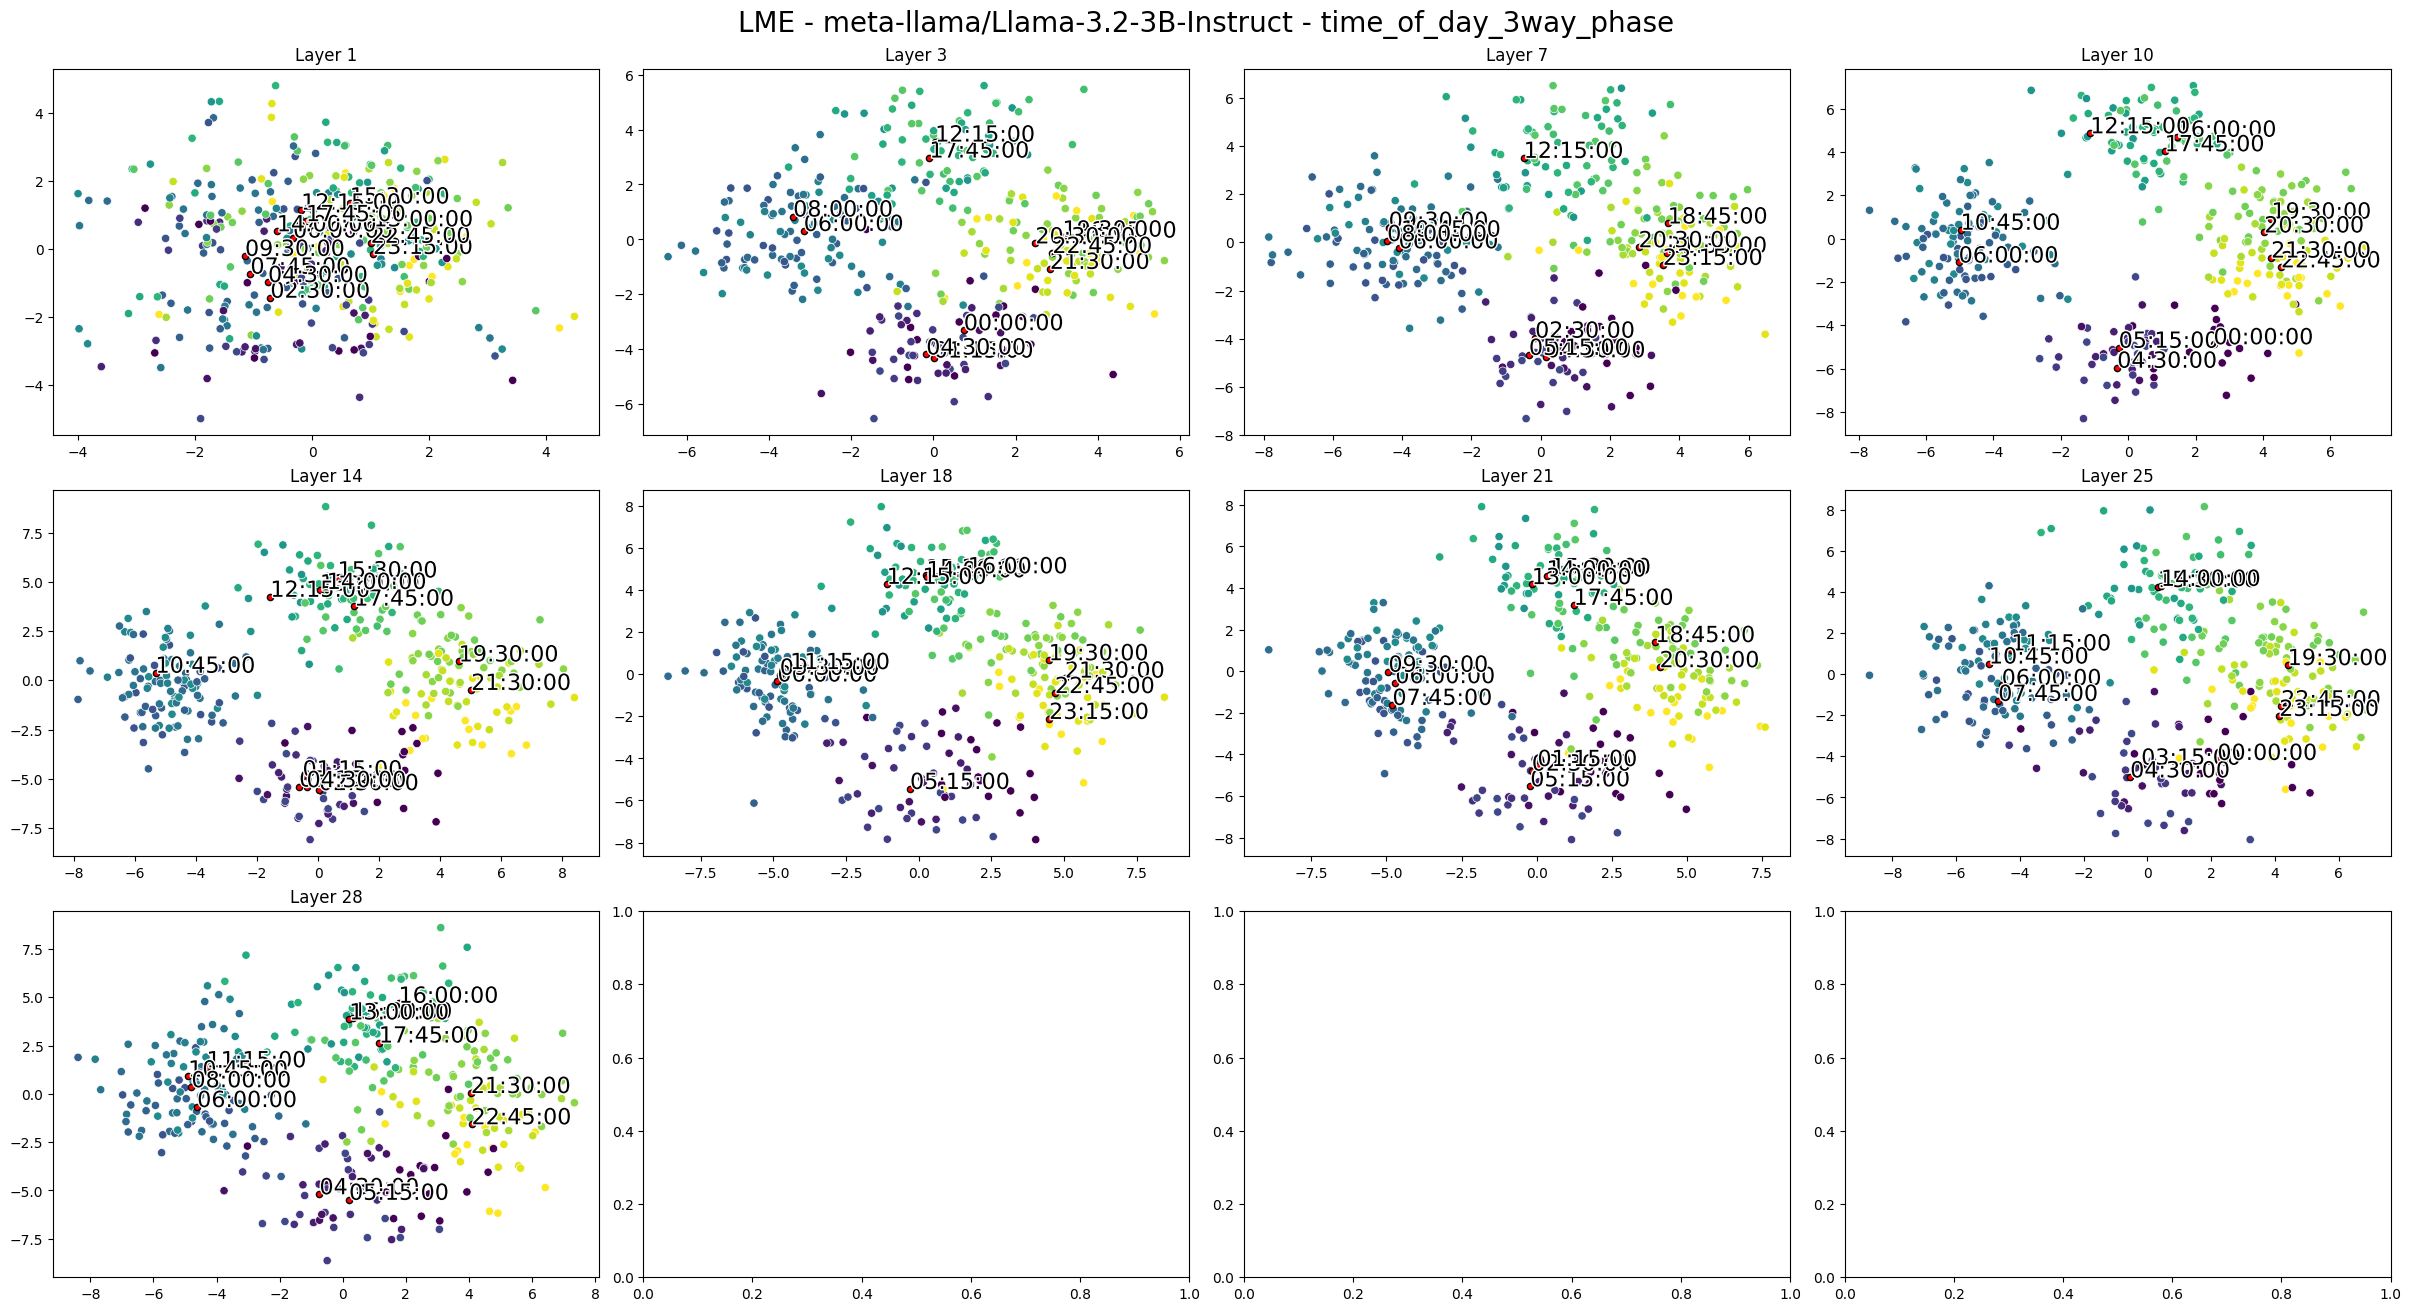

In [32]:
# General script for plotting activations
import random
from time_stuff.utils import ActivationDataset, LinearMetricEmbedder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.preprocessing import Normalizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import MDS
from umap import UMAP
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.patheffects as pe
from pycolormap_2d import ColorMap2DZiegler

def datetime_to_dayofyear(x):
    # Convert to datetime
    x = pd.to_datetime(x)
    # Get the day of the year
    return x.day_of_year

def datetime_to_month(x):
    # Convert to datetime
    x = pd.to_datetime(x)
    # Get the month
    return x.month


def plot_activations(ad: ActivationDataset, label_col: str, reduction_method, target_col='correct', layers=None, label_col_str=None,
                     n_components=2, graph='circular', title=None, save_path=None, preprocess_func=None, plots_per_row=4,
                     annotations='random', annotation_preprocess_func=None):
    if len(layers) < plots_per_row:
        plots_per_row = len(layers)

    norm = Normalizer()

    if reduction_method == 'PCA':
        rmodel = PCA(n_components=n_components)
    elif reduction_method == 'tSNE':
        rmodel = TSNE(n_components=n_components)
    elif reduction_method == 'Isomap':
        rmodel = Isomap(n_components=n_components)
    elif reduction_method == 'PLS':
        rmodel = PLSRegression(n_components=n_components)
    elif reduction_method == 'LDA':
        rmodel = LinearDiscriminantAnalysis(n_components=n_components)
    elif reduction_method == 'LME':
        rmodel = LinearMetricEmbedder(n_components=n_components, graph=graph, alpha=0.5)
    elif reduction_method == 'UMAP':
        rmodel = UMAP(n_components=n_components)
    elif reduction_method == 'MDS':
        rmodel = MDS(n_components=n_components)
    
    activations, labels = ad.get_slice(target_name=target_col, columns=label_col, preprocess_funcs=preprocess_func)
    labels = np.squeeze(labels)

    df = ad.get_metadata_df()

    # Split train and test sets
    split = 0.5
    activations_train = activations[:int(len(activations)*split)]
    activations_dev = activations[int(len(activations)*split):]

    labels_train = labels[:int(len(labels)*split)]
    labels_dev = labels[int(len(labels)*split):]

    df_train = df.iloc[:int(len(df)*split)].reset_index(drop=True)
    df_dev = df.iloc[int(len(df)*split):].reset_index(drop=True)

    # Standardize labels to 0-1 range
    if reduction_method in ['PLS']:
        min_label = labels_train.min()
        max_label = labels_train.max()
        labels_train = (labels_train-min_label)/(max_label-min_label)
        labels_dev = (labels_dev-min_label)/(max_label-min_label)

    if layers is None:
        layers = range(activations.shape[1])

    # Plot the data
    scaling_factor = 6 if len(layers) > 1 else 8
    fig, axs = plt.subplots(int(np.ceil(len(layers)/plots_per_row)), plots_per_row, figsize=(scaling_factor*plots_per_row, scaling_factor*len(layers)//plots_per_row), constrained_layout=True)

    for i, layer in tqdm(enumerate(layers)):
        if plots_per_row > 1:
            ax = axs[i//plots_per_row][i%plots_per_row]
        elif len(layers) > 1:
            ax = axs[i]
        else:
            ax = axs

        activations_layer_train = activations_train[:, layer]
        activations_layer_dev = activations_dev[:, layer]

        if reduction_method in ['PCA']:
            activations_layer_train = norm.fit_transform(activations_layer_train)
            activations_layer_dev = norm.transform(activations_layer_dev)
        
        if reduction_method in ['MDS']:
            activations_reduced_dev = rmodel.fit_transform(activations_layer_dev)
        else:
            # Fit the model
            rmodel.fit(activations_layer_train, labels_train)
            # Transform the data
            activations_reduced_train = rmodel.transform(activations_layer_train)
            activations_reduced_dev = rmodel.transform(activations_layer_dev)
        
        if reduction_method == 'LDA' and activations_reduced_dev.shape[1] <= 1:
            print(f"Layer {layer} has collinear centroids. Skipping.")
            continue
        
        if labels_dev.ndim > 1:
            # If labels are multi-dimensional, map them to 0-1 range
            cmap_labels_dev = (labels_dev - labels_dev.min(axis=0)) / (labels_dev.max(axis=0) - labels_dev.min(axis=0))
            # Use ColorMap2DZiegler to get bidimensional colors
            cmap = ColorMap2DZiegler()
            hues = [cmap(l1,l2) / 255.0 for l1, l2 in cmap_labels_dev]

            # Plot the data
            ax.scatter(activations_reduced_dev[:, 0], activations_reduced_dev[:, 1], c=hues, s=20)

        else:
            hues = labels_dev
            # Plot the data
            sns.scatterplot(x=activations_reduced_dev[:, 0], y=activations_reduced_dev[:, 1], hue=hues, ax=ax, palette='viridis')
            ax.get_legend().set_visible(False)
        # Set title
        ax.set_title(f"Layer {layer}")

        if reduction_method not in ['UMAP', 'MDS']:
            print(f"Layer: {layer} Score: {rmodel.score(activations_layer_dev, labels_dev)}")

        if label_col_str is not None:
            if annotations == 'random':
                # Select a few random sentences
                indices = np.random.choice(len(activations_layer_dev), size=10, replace=False)
                rnd_activations = activations_reduced_dev[indices]
                txt = df_dev.iloc[indices][label_col_str].values

                points = rnd_activations

            elif annotations == 'class':
                # Select sentences so that they represent one item per class in label_col_str
                unique_labels = df_dev[label_col_str].unique()
                indices = []
                for label in unique_labels:
                    # Get the index of the first occurrence of the label
                    idx = df_dev[df_dev[label_col_str] == label].index[0]
                    indices.append(idx)
                
                # Get the activations and sentences for the selected indices
                rnd_activations = activations_reduced_dev[indices]
                txt = df_dev.iloc[indices][label_col_str].values

                points = rnd_activations


            elif annotations=='centroids':
                # Compute the centroids of each class
                centroids = []
                unique_labels = np.unique(labels_dev)
                
                # Cap the number of centroids to 12
                if unique_labels.shape[0] > 12:
                    unique_labels = np.random.choice(unique_labels, size=12, replace=False)

                for label in unique_labels:
                    # Get the indices of the samples with the current label
                    indices = np.where(labels_dev == label)[0]
                    # Compute the centroid of the samples with the current label
                    centroid = np.mean(activations_reduced_dev[indices], axis=0)
                    centroids.append(centroid)
                centroids = np.array(centroids)

                # Compute the corresponding txt
                txt = []
                for label in unique_labels:
                    # Get the indices of the samples with the current label
                    indices = np.where(labels_dev == label)[0]
                    # Get the first sample with the current label
                    txt.append(df_dev.iloc[indices[0]][label_col_str])
                points = centroids

            else:
                raise ValueError("Invalid annotations value. Use 'random', 'class' or 'centroids'.")

            # Plot the points
            ax.scatter(points[:, 0], points[:, 1], color='red', edgecolor='k', s=20)

            if annotation_preprocess_func is not None:
                # Preprocess the text
                txt = [annotation_preprocess_func(t) for t in txt]

            # Annotate the points
            for j, txt in enumerate(txt):
                ax.annotate(txt, (points[j, 0], points[j, 1]), fontsize=16,  path_effects=[pe.withStroke(linewidth=2, foreground="white")])


    # Set the title
    if title is not None:
        fig.suptitle(title, fontsize=20)
    else:
        fig.suptitle(f"{reduction_method} - {ad.model_name} - {ad.dataset_name}", fontsize=20)

    
    # plt.tight_layout()
    if not save_path:
        plt.show()
    else:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)

linspace = np.linspace(0, 1, 9)

# ad = ActivationDataset.load('results/gpt2/season_3way.pt')
# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/season_3way.pt')
# # # layers = range(0, ad.n_layers, )
# # layers = [int(np.clip(ad.n_layers * p, a_min=1, a_max=ad.n_layers-1)) for p in linspace]
# layers = [28]
# plot_activations(ad, label_col='correct_season_label', layers=layers, reduction_method='LME', label_col_str='correct_season',
#                  plots_per_row=2, annotations='centroids', graph='circular')

# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/time_of_day_HH:MM.pt')
# layers = range(1, ad.n_layers, 1)
# layers = [int(np.clip(ad.n_layers * p, a_min=1, a_max=ad.n_layers-1)) for p in linspace]
# layers = [8]
# plot_activations(ad, label_col='correct_hour', layers=layers, reduction_method='LDA', label_col_str='correct', annotations='centroids',
#                  plots_per_row=4, graph='circular' )

# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way_month.pt')
# # layers = range(0, ad.n_layers, 4)
# layers = [int(np.clip(ad.n_layers * p, a_min=0, a_max=ad.n_layers-1)) for p in linspace]
# layers = [19]
# # plot_activations(ad, label_col='correct_date', layers=layers, reduction_method='PLS', label_col_str='correct_month', 
# #                  graph='euclidean', preprocess_func=datetime_to_dayofyear)
# plot_activations(ad, label_col='correct_month_label', layers=layers, reduction_method='LDA', label_col_str='correct_month', 
#                  graph='euclidean', plots_per_row=2, annotations='centroids')

# ad = ActivationDataset.load('results/gpt2/duration_1way_0hop.pt')
# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/duration_3way.pt')
# # layers = [int(np.clip(ad.n_layers * p, a_min=1, a_max=ad.n_layers-1)) for p in linspace]
# # layers = range(1, ad.n_layers, 1)
# layers = [3, 11, 18, 27]

# plot_activations(ad, label_col=['correct_duration_days', 'correct_date'], target_col='correct', layers=layers, reduction_method='LME', plots_per_row=2,
#                  label_col_str=['correct_month', 'correct_duration_str'], preprocess_func=[lambda x: np.log(x), datetime_to_dayofyear], graph='euclidean', annotations='random',
#                  annotation_preprocess_func=lambda x: x[0] + '\n' + x[1])

# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way.pt')
# print(ad.get_accuracy())
# # layers = range(0, ad.n_layers, 4)
# layers = [int(np.clip(ad.n_layers * p, a_min=0, a_max=ad.n_layers-1)) for p in linspace]
# plot_activations(ad, label_col='correct_date', layers=layers, reduction_method='PCA', label_col_str='correct_date', 
#                  preprocess_func=datetime_to_month, plots_per_row=3, graph='circular')

# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way_2hop.pt')
# print(ad.get_accuracy())
# # layers = range(0, ad.n_layers, 4)
# layers = [int(np.clip(ad.n_layers * p, a_min=0, a_max=ad.n_layers-1)) for p in linspace]
# plot_activations(ad, label_col='correct_date', layers=layers, reduction_method='LME', label_col_str='correct_date', 
#                  preprocess_func=datetime_to_dayofyear, plots_per_row=3, graph='euclidean')

# ad = ActivationDataset.load('results/gpt2/date_3way.pt')
# layers = range(0, ad.n_layers, 2)
# plot_activations(ad, label_col='correct_date', layers=layers, reduction_method='PCA', label_col_str='correct_date')

# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/time_of_day_3way.pt')
# # layers = range(1, ad.n_layers, 1)
# layers = [int(np.clip(ad.n_layers * p, a_min=1, a_max=ad.n_layers-1)) for p in linspace]
# # layers = [8]
# plot_activations(ad, label_col='correct_time', target_col='correct_time_expr', layers=layers, reduction_method='LME', label_col_str='correct_time', annotations='centroids',
#                  plots_per_row=4, graph='circular', preprocess_func=lambda x: pd.to_datetime(x).hour)

ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/time_of_day_3way_phase.pt')
# layers = range(1, ad.n_layers, 1)
layers = [int(np.clip(ad.n_layers * p, a_min=1, a_max=ad.n_layers-1)) for p in linspace]
# layers = [8]
plot_activations(ad, label_col='correct_time', layers=layers, reduction_method='LME', label_col_str='correct_time', annotations='centroids',
                 plots_per_row=4, graph='circular', preprocess_func=lambda x: pd.to_datetime(x).hour)
# plot_activations(ad, label_col='correct_time', target_col='correct_time_expr', layers=layers, reduction_method='LME', label_col_str='correct_time', annotations='centroids',
#                  plots_per_row=4, graph='circular', preprocess_func=lambda x: pd.to_datetime(x).hour)





In [21]:
import random
import pandas as pd
pd.to_datetime('23:00:00').hour


23

Layer 8 score: -0.10415640267872828
Layer 9 score: -0.2183318985602496
Layer 10 score: -0.045187666950203154
Layer 11 score: 0.10213734100564276
Layer 12 score: 0.15762070400492556
Layer 13 score: 0.05227023598225411
Layer 14 score: 0.08437938636825415
Layer 15 score: -0.01820864600922789
Layer 16 score: -0.10021029114116753
Layer 17 score: -0.15588249223944461
Layer 18 score: -0.26172386540762815
Layer 19 score: -0.25305891991957563
Layer 20 score: -0.23590238688422338
Layer 21 score: -0.22092874626102854
Best layer: 12, score: 0.15762070400492556


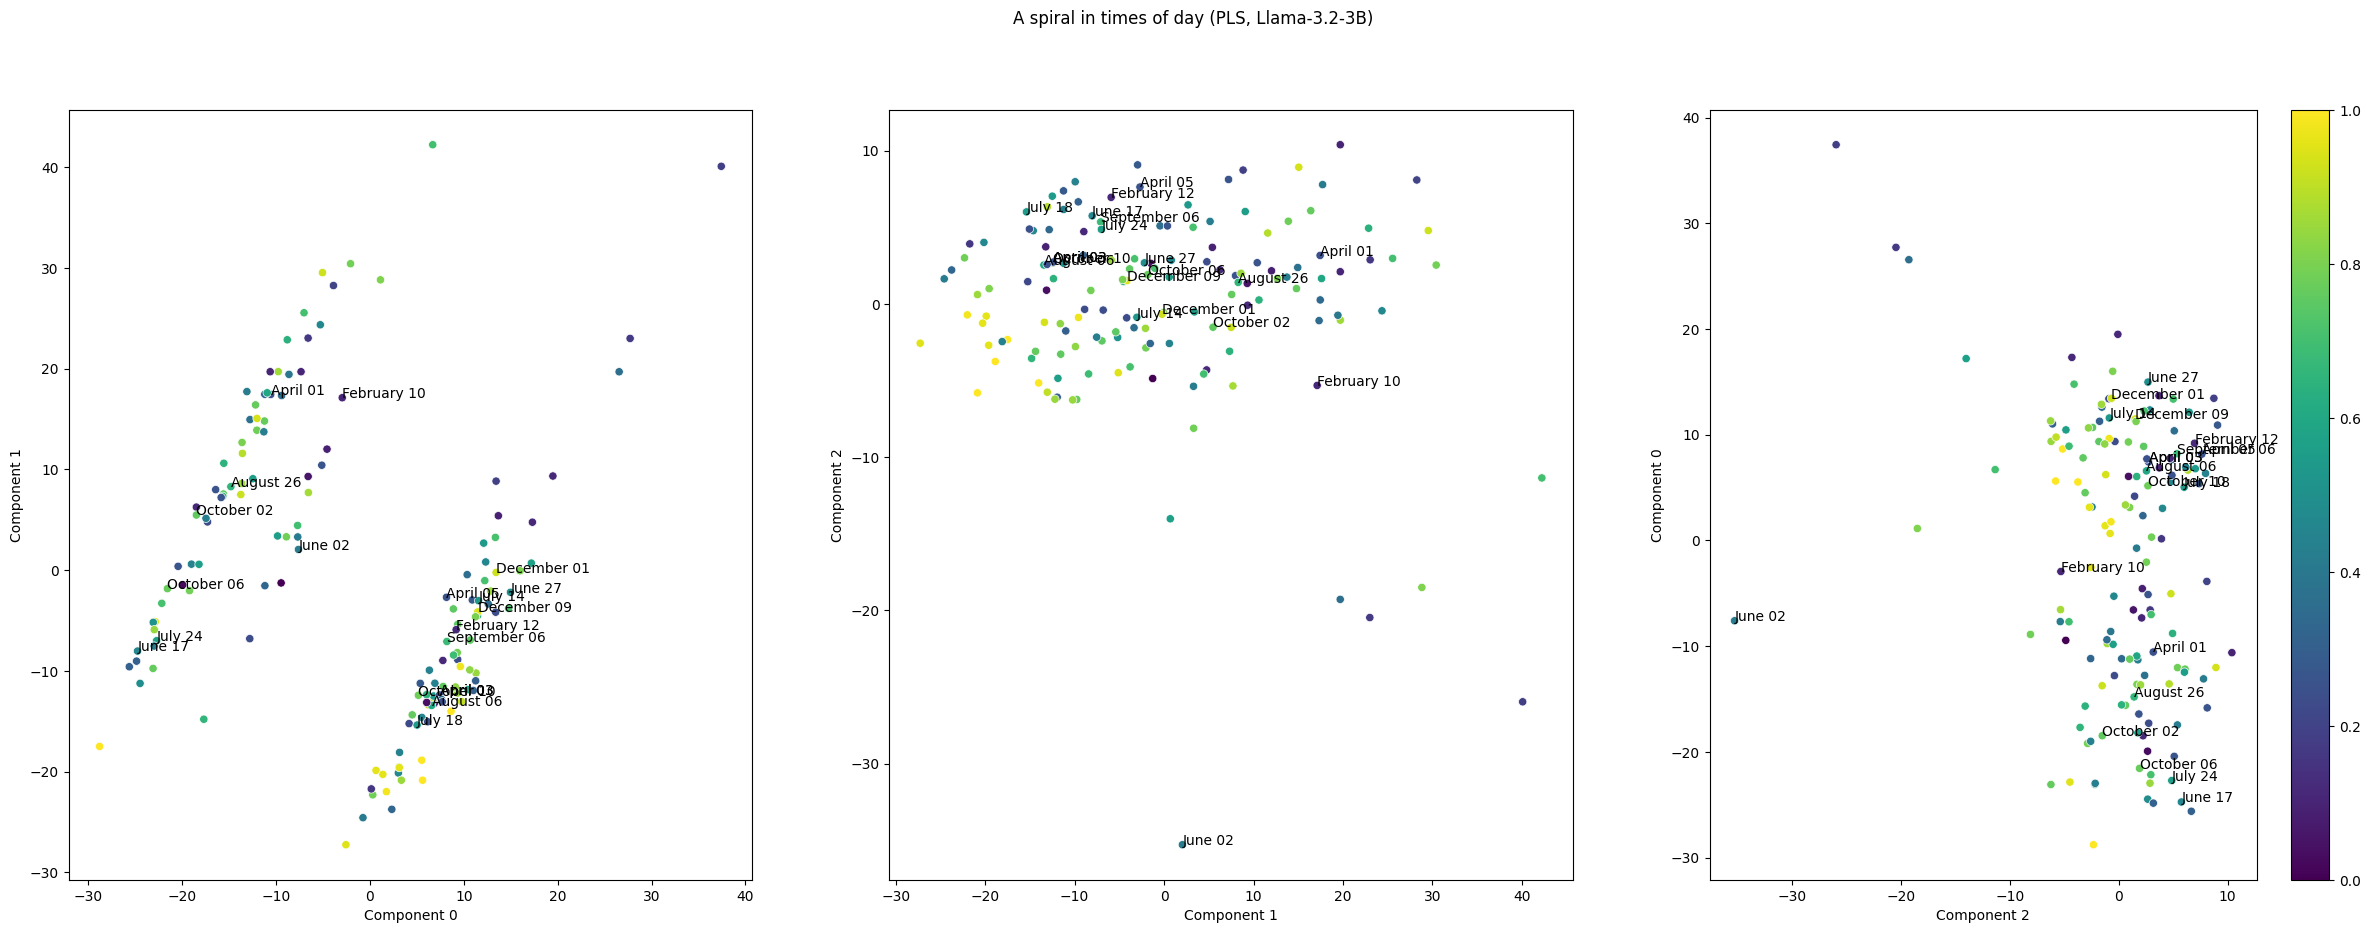

In [ ]:
# PLS regression
best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    if i/len(activations_train) < 0.25 or i/len(activations_train) > 0.75:
        continue
    pls = PLSRegression(n_components=10)
    pls.fit(layer, labels_train)
    score = pls.score(activations_dev[i], labels_dev)
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

best_layer = 12 # Override best layer


pls = PLSRegression(n_components=3)
# rnd = np.random.randn(*layer.shape)
pls.fit(activations_train[best_layer], labels_train)
# pls.fit(rnd, labels_train)


# pls_train = pls.transform(activations_train[best_layer])
pls_test = pls.transform(activations_test[best_layer])

# Generate 10 indices
indices = np.random.choice(len(activations_test[best_layer]), 20)
# Get sentences and acivations
if 'sentence' in test_set.columns:
    rnd_sent = test_set['sentence'].iloc[indices]
elif 'correct_date' in test_set.columns:
    rnd_sent = test_set['correct_date'].iloc[indices]
    # Parse as month day
    rnd_sent = pd.to_datetime(rnd_sent).dt.strftime('%B %d')
elif 'correct_time' in test_set.columns:
    rnd_sent = test_set['correct_time'].iloc[indices]
    # Parse as hour minute
    rnd_sent = pd.to_datetime(rnd_sent).dt.strftime('%H:%M')
rnd_activations = activations_test[best_layer][indices]
# Transform activations
rnd_activations = pls.transform(rnd_activations)

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i, ax in enumerate(axs):
    # sns.scatterplot(x=pls_train[:, i%3], y=pls_train[:, (i+1)%3], hue=train_set['label'], ax=ax, palette='viridis')
    sns.scatterplot(x=pls_test[:, i%3], y=pls_test[:, (i+1)%3], hue=labels_test, ax=ax, palette='viridis')
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i%3], rnd_activations[j, (i+1)%3]))
    ax.set_xlabel(f'Component {i%3}')
    ax.set_ylabel(f'Component {(i+1)%3}')
    ax.get_legend().set_visible(False)


fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs[2])
# Set title
plt.suptitle('A spiral in times of day (PLS, Llama-3.2-3B)')
plt.show()

In [ ]:
# Double PLS regression on labels and secondary labels on all layers
import matplotlib.patheffects as pe
from pycolormap_2d import ColorMap2DZiegler

best_score = 0
best_layer = 0
transformed_list1 = []
transformed_list2 = []
rnd_activations1 = []
rnd_activations2 = []
indices = np.random.choice(len(activations_test[0]), 15)

for i, layer in enumerate(activations_train):
    if i/len(activations_train) < 0.25 or i/len(activations_train) > 0.75:
        continue
    pls1 = PLSRegression(n_components=5)
    pls2 = PLSRegression(n_components=5)
    pls1.fit(layer, labels_train)
    pls2.fit(layer, secondary_labels_train)
    score1 = pls1.score(activations_dev[i], labels_dev)
    score2 = pls2.score(activations_dev[i], secondary_labels_dev)
    score = (score1 + score2) / 2
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i

    transformed_test1 = pls1.transform(activations_test[i])
    transformed_test2 = pls2.transform(activations_test[i])

    transformed_list1.append(transformed_test1)
    transformed_list2.append(transformed_test2)

    # rnd_sent = test_set.iloc[indices].apply(lambda x: str(pd.to_datetime(x['correct_date']).strftime('%d/%m')) + " " + str(pd.to_datetime(x['correct_end_date']).strftime('%d/%m')), axis=1)
    rnd_sent = test_set.iloc[indices].apply(lambda x: str(pd.to_datetime(x['correct_date']).strftime('%d/%m')) + " " + str(x['correct_duration_str']), axis=1)
    # rnd_sent = test_set.iloc[indices].apply(lambda x: str(x['context']), axis=1)
    rnd_activations1.append(transformed_test1[indices])
    rnd_activations2.append(transformed_test2[indices])


print(f'Best layer: {best_layer}, score: {best_score}')


# Plotting
fig, axs = plt.subplots(int(np.ceil(len(transformed_list1)/4)), 4, figsize=(30, 30))

norm_labels1 = (labels_test - labels_test.min()) / (labels_test.max() - labels_test.min())
norm_labels2 = (secondary_labels_test - secondary_labels_test.min()) / (secondary_labels_test.max() - secondary_labels_test.min())

cmap = ColorMap2DZiegler()
hues = [cmap(l1,l2) / 255.0 for l1, l2 in zip(norm_labels1, norm_labels2)]

for i in range(len(transformed_list1)):
    # sns.scatterplot(x=transformed_list1[i][:, 0], y=transformed_list2[i][:, 0], hue=hues, ax=axs[i//4][i%4], palette='viridis')
    axs[i//4][i%4].scatter(transformed_list1[i][:, 0], transformed_list2[i][:, 0], color=hues)
    # axs[i//4][i%4].get_legend().set_visible(False)

    # Set max and min for x and y axes to 0.5
    axs[i//4][i%4].set_xlim(-20, 20)
    axs[i//4][i%4].set_ylim(-25, 25)

    # Annotate a few points only if they fall in the range
    for j, txt in enumerate(rnd_sent):
        if rnd_activations1[i][j, 0] < axs[i//4][i%4].get_xlim()[1] and rnd_activations1[i][j, 0] > axs[i//4][i%4].get_xlim()[0] and rnd_activations2[i][j, 0] < axs[i//4][i%4].get_ylim()[1] and rnd_activations2[i][j, 0] > axs[i//4][i%4].get_ylim()[0]:
            # axs[i//4][i%4].annotate(txt, (rnd_activations1[i][j, 0], rnd_activations2[i][j, 0]))
            axs[i//4][i%4].text(rnd_activations1[i][j, 0], rnd_activations2[i][j, 0], txt, path_effects=[pe.withStroke(linewidth=2, foreground="white")])


# Set title
plt.suptitle('Two-dimensional linear features (PLS)', fontsize=16)
plt.show()

In [ ]:
# 2D PLS regression on double labels on all layers
import matplotlib.patheffects as pe
from pycolormap_2d import ColorMap2DZiegler

best_score = 0
best_layer = 0
transformed_list = []
rnd_activations = []
indices = np.random.choice(len(activations_test[0]), 15)

for i, layer in enumerate(activations_train):
    if i/len(activations_train) < 0.25 or i/len(activations_train) > 0.75:
        continue
    pls = PLSRegression(n_components=5)
    pls.fit(layer, joint_labels_train.to_numpy())
    score = pls.score(activations_dev[i], joint_labels_dev.to_numpy())
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i

    transformed_test = pls.transform(activations_test[i])

    transformed_list.append(transformed_test)

    # rnd_sent = test_set.iloc[indices].apply(lambda x: str(pd.to_datetime(x['correct_date']).strftime('%d/%m')) + " " + str(pd.to_datetime(x['correct_end_date']).strftime('%d/%m')), axis=1)
    rnd_sent = test_set.iloc[indices].apply(lambda x: str(pd.to_datetime(x['correct_date']).strftime('%d/%m')) + " " + str(x['correct_duration_str']), axis=1)
    # rnd_sent = test_set.iloc[indices].apply(lambda x: str(x['context']), axis=1)
    rnd_activations.append(transformed_test[indices])


print(f'Best layer: {best_layer}, score: {best_score}')


# Plotting
fig, axs = plt.subplots(int(np.ceil(len(transformed_list)/4)), 4, figsize=(30, 30))

# norm_labels1 = (labels_test - labels_test.min()) / (labels_test.max() - labels_test.min())
# norm_labels2 = (secondary_labels_test - secondary_labels_test.min()) / (secondary_labels_test.max() - secondary_labels_test.min())

norm_labels = (joint_labels_test - joint_labels_test.min()) / (joint_labels_test.max() - joint_labels_test.min())

cmap = ColorMap2DZiegler()
hues = [cmap(l1,l2) / 255.0 for l1, l2 in norm_labels.to_numpy()]

for i in range(len(transformed_list)):
    # sns.scatterplot(x=transformed_list1[i][:, 0], y=transformed_list2[i][:, 0], hue=hues, ax=axs[i//4][i%4], palette='viridis')
    axs[i//4][i%4].scatter(transformed_list[i][:, 0], transformed_list[i][:, 1], color=hues)
    # axs[i//4][i%4].get_legend().set_visible(False)

    # Annotate a few points
    for j, txt in enumerate(rnd_sent):
        # axs[i//4][i%4].annotate(txt, (rnd_activations1[i][j, 0], rnd_activations2[i][j, 0]))
        axs[i//4][i%4].text(rnd_activations[i][j, 0], rnd_activations[i][j, 1], txt, path_effects=[pe.withStroke(linewidth=2, foreground="white")])
    # Set max and min for x and y axes to 0.5
    # axs[i//4][i%4].set_xlim(-20, 20)
    # axs[i//4][i%4].set_ylim(-20, 20)

# Set title
plt.suptitle('Two-dimensional linear features (PLS)', fontsize=16)
plt.show()

In [ ]:
# Plot directly primary and secondary labels
# Make two plots side by side, one with hue primary labels and one with hue secondary labels
fig, axs = plt.subplots(1, 2, figsize=(30, 15))
# sns.scatterplot(x=labels_test, y=secondary_labels_test, hue=labels_test, ax=axs[0], palette='viridis')
axs[0].scatter(labels_test, secondary_labels_test, color=hues)
axs[0].set_xlabel('Primary label')
axs[0].set_ylabel('Secondary label')
axs[0].set_title('Primary and secondary labels')

# sns.scatterplot(x=labels_test, y=secondary_labels_test, hue, ax=axs[1], palette='viridis')
axs[1].scatter(labels_test, secondary_labels_test, color=hues)
axs[1].set_xlabel('Primary label')
axs[1].set_ylabel('Secondary label')
axs[1].set_title('Primary and secondary labels')

plt.show()

Layer 8 score: 0.03162156565141462
Layer 9 score: 0.031720443742305475
Layer 10 score: 0.04500756230885198
Layer 11 score: 0.03846976358215175
Layer 12 score: 0.04880684541389354
Layer 13 score: 0.05445930896676809
Layer 14 score: 0.054778674006785565
Layer 15 score: 0.05688667085421634
Layer 16 score: 0.06194878526305963
Layer 17 score: 0.06089770116000098
Layer 18 score: 0.05585780174542706
Layer 19 score: 0.0563484323230465
Layer 20 score: 0.05765112450050166
Layer 21 score: 0.059692487543665275
Best layer: 16, score: 0.06194878526305963


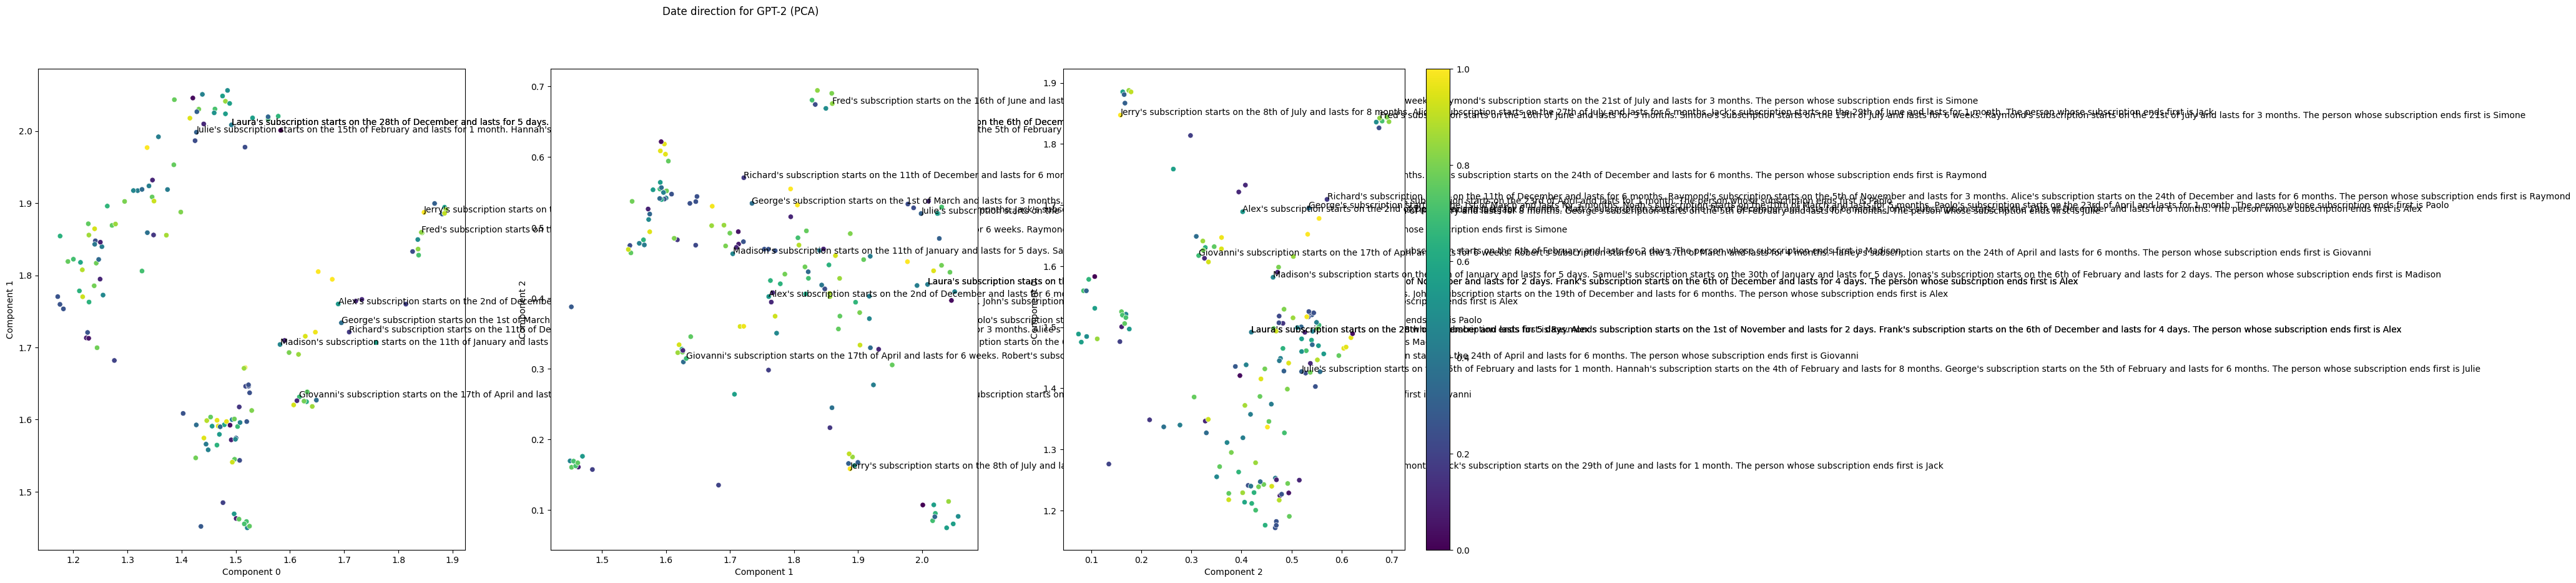

In [ ]:
# PCA with a continuous label

best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    if i / len(activations_train) < 0.25 or i / len(activations_train) > 0.75:
        continue
    nm = Normalizer()
    pca = PCA(n_components=3)
    nm.fit(layer)
    pca.fit(nm.transform(layer))
    transformed_train = pca.transform(nm.transform(layer))
    transformed_dev = pca.transform(nm.transform(activations_dev[i]))
    score = np.corrcoef(transformed_dev[:, 0], labels_dev)[0, 1]  # Correlation as a proxy for score
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

# best_layer = 16 # Override best layer

pca = PCA(n_components=3)
nm = Normalizer()
# nm.fit(activations_train[best_layer])
pca.fit(activations_train[best_layer])

pca_test = pca.transform(nm.transform(activations_test[best_layer]))

# Generate 10 indices
indices = np.random.choice(len(activations_test[best_layer]), 10)
# Get sentences and activations
if 'context' in df.columns:
    # Concatenate context and correct columns
    rnd_sent = df['context'].iloc[indices] + " " + df['correct'].iloc[indices]

elif 'sentence' in df.columns:
    rnd_sent = df['sentence'].iloc[indices]
else:
    raise ValueError('No sentence column found in dataframe')
rnd_activations = activations_test[best_layer][indices]
# Transform activations
rnd_activations = pca.transform(nm.transform(rnd_activations))

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i, ax in enumerate(axs):
    # sns.scatterplot(x=pca_train[:, i % 3], y=pca_train[:, (i + 1) % 3], hue=train_set['label'], ax=ax, palette='viridis')
    sns.scatterplot(x=pca_test[:, i % 3], y=pca_test[:, (i + 1) % 3], hue=labels_test, ax=ax, palette='viridis')
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i % 3], rnd_activations[j, (i + 1) % 3]))
    ax.set_xlabel(f'Component {i % 3}')
    ax.set_ylabel(f'Component {(i + 1) % 3}')
    ax.get_legend().set_visible(False)

fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs[2])
# Set title
plt.suptitle('Date direction for GPT-2 (PCA)')
plt.show()

In [ ]:
# PCA with a continuous label on all layers
component1 = 0
component2 = 1

best_score = 0
best_layer = 0
transformed_test_list = []
rnd_activations = []
# Generate 10 indices
indices = np.random.choice(len(activations_test[0]), 7)
for i, layer in enumerate(activations_train):
    nm = Normalizer()
    pca = PCA(n_components=5)
    nm.fit(layer)
    pca.fit(nm.transform(layer))
    transformed_train = pca.transform(nm.transform(layer))
    transformed_dev = pca.transform(nm.transform(activations_dev[i]))
    transformed_test = pca.transform(nm.transform(activations_test[i]))
    transformed_test_list.append(transformed_test)
    score = np.corrcoef(transformed_dev[:, 0], labels_dev)[0, 1]  # Correlation as a proxy for score
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i

    
    # rnd_sent = test_set.iloc[indices].apply(lambda x: str(x['context']) + ' ' + str(x['correct']), axis=1)
    if 'correct_date' in test_set.columns:
        rnd_sent = test_set.iloc[indices].apply(lambda x: str(x['correct_date'].strftime('%B %d')), axis=1)
    elif 'correct_time' in test_set.columns:
        rnd_sent = test_set.iloc[indices].apply(lambda x: str(x['correct_time'].strftime('%H:%M')), axis=1)

    rnd_activations.append(transformed_test[indices])
    
print(f'Best layer: {best_layer}, score: {best_score}')

# Plot results in subplots. Put four subplots in one row
fig, axs = plt.subplots(int(np.ceil(len(transformed_test_list)/4)), 4, figsize=(30, 30))
for i in range(len(transformed_test_list)):
    sns.scatterplot(x=transformed_test_list[i][:, component1], y=transformed_test_list[i][:, component2], hue=labels_test, ax=axs[i//4][i%4], palette='viridis')
    axs[i//4][i%4].get_legend().set_visible(False)

    # Annotate a few points
    for j, txt in enumerate(rnd_sent):
        axs[i//4][i%4].annotate(txt, (rnd_activations[i][j, component1], rnd_activations[i][j, component2]))
    # Set max and min for x and y axes to 0.5
    # axs[i//4][i%4].set_xlim(0, 0.05)
    # axs[i//4][i%4].set_ylim(-0.05, 0.05)

# Set title
plt.suptitle('Directions across layers (PCA)', fontsize=16)
plt.show()

In [ ]:
# LDA with a discrete label on all layers

component1 = 0
component2 = 1

if 'correct_date' in test_set.columns:
    discrete_labels_train = train_set['correct_date'].apply(lambda x: x.month)
    discrete_labels_test = test_set['correct_date'].apply(lambda x: x.month)
elif 'correct_time' in test_set.columns:
    discrete_labels_train = train_set['correct_time'].apply(lambda x: x.hour)
    discrete_labels_test = test_set['correct_time'].apply(lambda x: x.hour)
    # discrete_labels_train = pd.to_datetime(train_set['time']).apply(lambda x: x.hour)
    # discrete_labels_test = pd.to_datetime(test_set['time']).apply(lambda x: x.hour)

transformed_test_list = []
rnd_activations = []

# Generate 7 random indices
indices = np.random.choice(len(activations_test[0]), 20)

for i, layer in enumerate(activations_train):
    nm = Normalizer()
    nm.fit(layer)

    norm_train = nm.transform(layer)
    norm_dev = nm.transform(activations_dev[i])
    norm_test = nm.transform(activations_test[i])

    # Fit LDA using train set and train labels
    lda = LDA(n_components=2)
    lda.fit(norm_train, discrete_labels_train)

    # Transform test set
    transformed_test = lda.transform(norm_test)

    transformed_test_list.append(transformed_test)
    rnd_activations.append(transformed_test[indices])

    if 'correct_date' in test_set.columns:
        rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_date'].strftime('%B %d'), axis=1)
    elif 'correct_time' in test_set.columns:
        # rnd_sent = test_set.iloc[indices].apply(lambda x: format_time(x['correct_time']), axis=1)
        rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_time'].strftime('%H:%M'), axis=1)
        # rnd_sent = pd.to_datetime(test_set['time']).iloc[indices].apply(lambda x: x.strftime('%H:%M'))

# Plotting
fig, axs = plt.subplots(int(np.ceil(len(transformed_test_list)/4)), 4, figsize=(30, 30))

for i in range(len(transformed_test_list)):
    ax = axs[i//4][i%4]
    sns.scatterplot(x=transformed_test_list[i][:, component1],
                    y=transformed_test_list[i][:, component2],
                    hue=labels_test, ax=ax, palette='twilight_shifted')
    ax.get_legend().set_visible(False)

    for j, txt in enumerate(rnd_sent):
        # Text must have a white outline
        ax.annotate(txt, (rnd_activations[i][j, component1], rnd_activations[i][j, component2]))
                        # fontsize=12, color='white', weight='bold',
                        # bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.3'))

plt.suptitle('Date direction across layers (LDA)', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# LME with a discrete label on all layers



if 'correct_season' in test_set.columns:
    discrete_labels_train = train_set['correct_season'].apply(lambda x: 0 if x == 'winter' else (1 if x == 'spring' else (2 if x == 'summer' else 3))).to_numpy()
    discrete_labels_test = test_set['correct_season'].apply(lambda x: 0 if x == 'winter' else (1 if x == 'spring' else (2 if x == 'summer' else 3))).to_numpy()
elif 'correct_date' in test_set.columns:
    discrete_labels_train = train_set['correct_date'].apply(lambda x: x.month).to_numpy()
    discrete_labels_test = test_set['correct_date'].apply(lambda x: x.month).to_numpy()
elif 'correct_time' in test_set.columns:
    discrete_labels_train = train_set['correct_time'].apply(lambda x: x.hour).to_numpy()
    discrete_labels_test = test_set['correct_time'].apply(lambda x: x.hour).to_numpy()
    # discrete_labels_train = pd.to_datetime(train_set['time']).apply(lambda x: x.hour)
    # discrete_labels_test = pd.to_datetime(test_set['time']).apply(lambda x: x.hour)

transformed_test_list = []
rnd_activations = []

# Generate 7 random indices
indices = np.random.choice(len(activations_test[0]), 20)

for i, layer in tqdm(enumerate(activations_train), total=len(activations_train)):
    # Fit lme using train set and train labels
    lme = LinearMetricEmbedder(n_components=3, graph='circular')
    lme.fit(layer, discrete_labels_train)

    # Transform test set
    transformed_test = lme.transform(activations_test[i])

    transformed_test_list.append(transformed_test)
    rnd_activations.append(transformed_test[indices])

    if 'correct_date' in test_set.columns:
        rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_date'].strftime('%B %d'), axis=1)
    elif 'correct_time' in test_set.columns:
        # rnd_sent = test_set.iloc[indices].apply(lambda x: format_time(x['correct_time']), axis=1)
        rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_time'].strftime('%H:%M'), axis=1)
        # rnd_sent = pd.to_datetime(test_set['time']).iloc[indices].apply(lambda x: x.strftime('%H:%M'))

# Plotting
component1 = 0
component2 = 1

fig, axs = plt.subplots(int(np.ceil(len(transformed_test_list)/4)), 4, figsize=(30, 30))

for i in range(len(transformed_test_list)):
    ax = axs[i//4][i%4]
    sns.scatterplot(x=transformed_test_list[i][:, component1],
                    y=transformed_test_list[i][:, component2],
                    hue=labels_test, ax=ax, palette='twilight_shifted')
    ax.get_legend().set_visible(False)

    for j, txt in enumerate(rnd_sent):
        # Text must have a white outline
        ax.annotate(txt, (rnd_activations[i][j, component1], rnd_activations[i][j, component2]))
                        # fontsize=12, color='white', weight='bold',
                        # bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.3'))

plt.suptitle('Date direction across layers (LME)', fontsize=16)
plt.tight_layout()
plt.show()


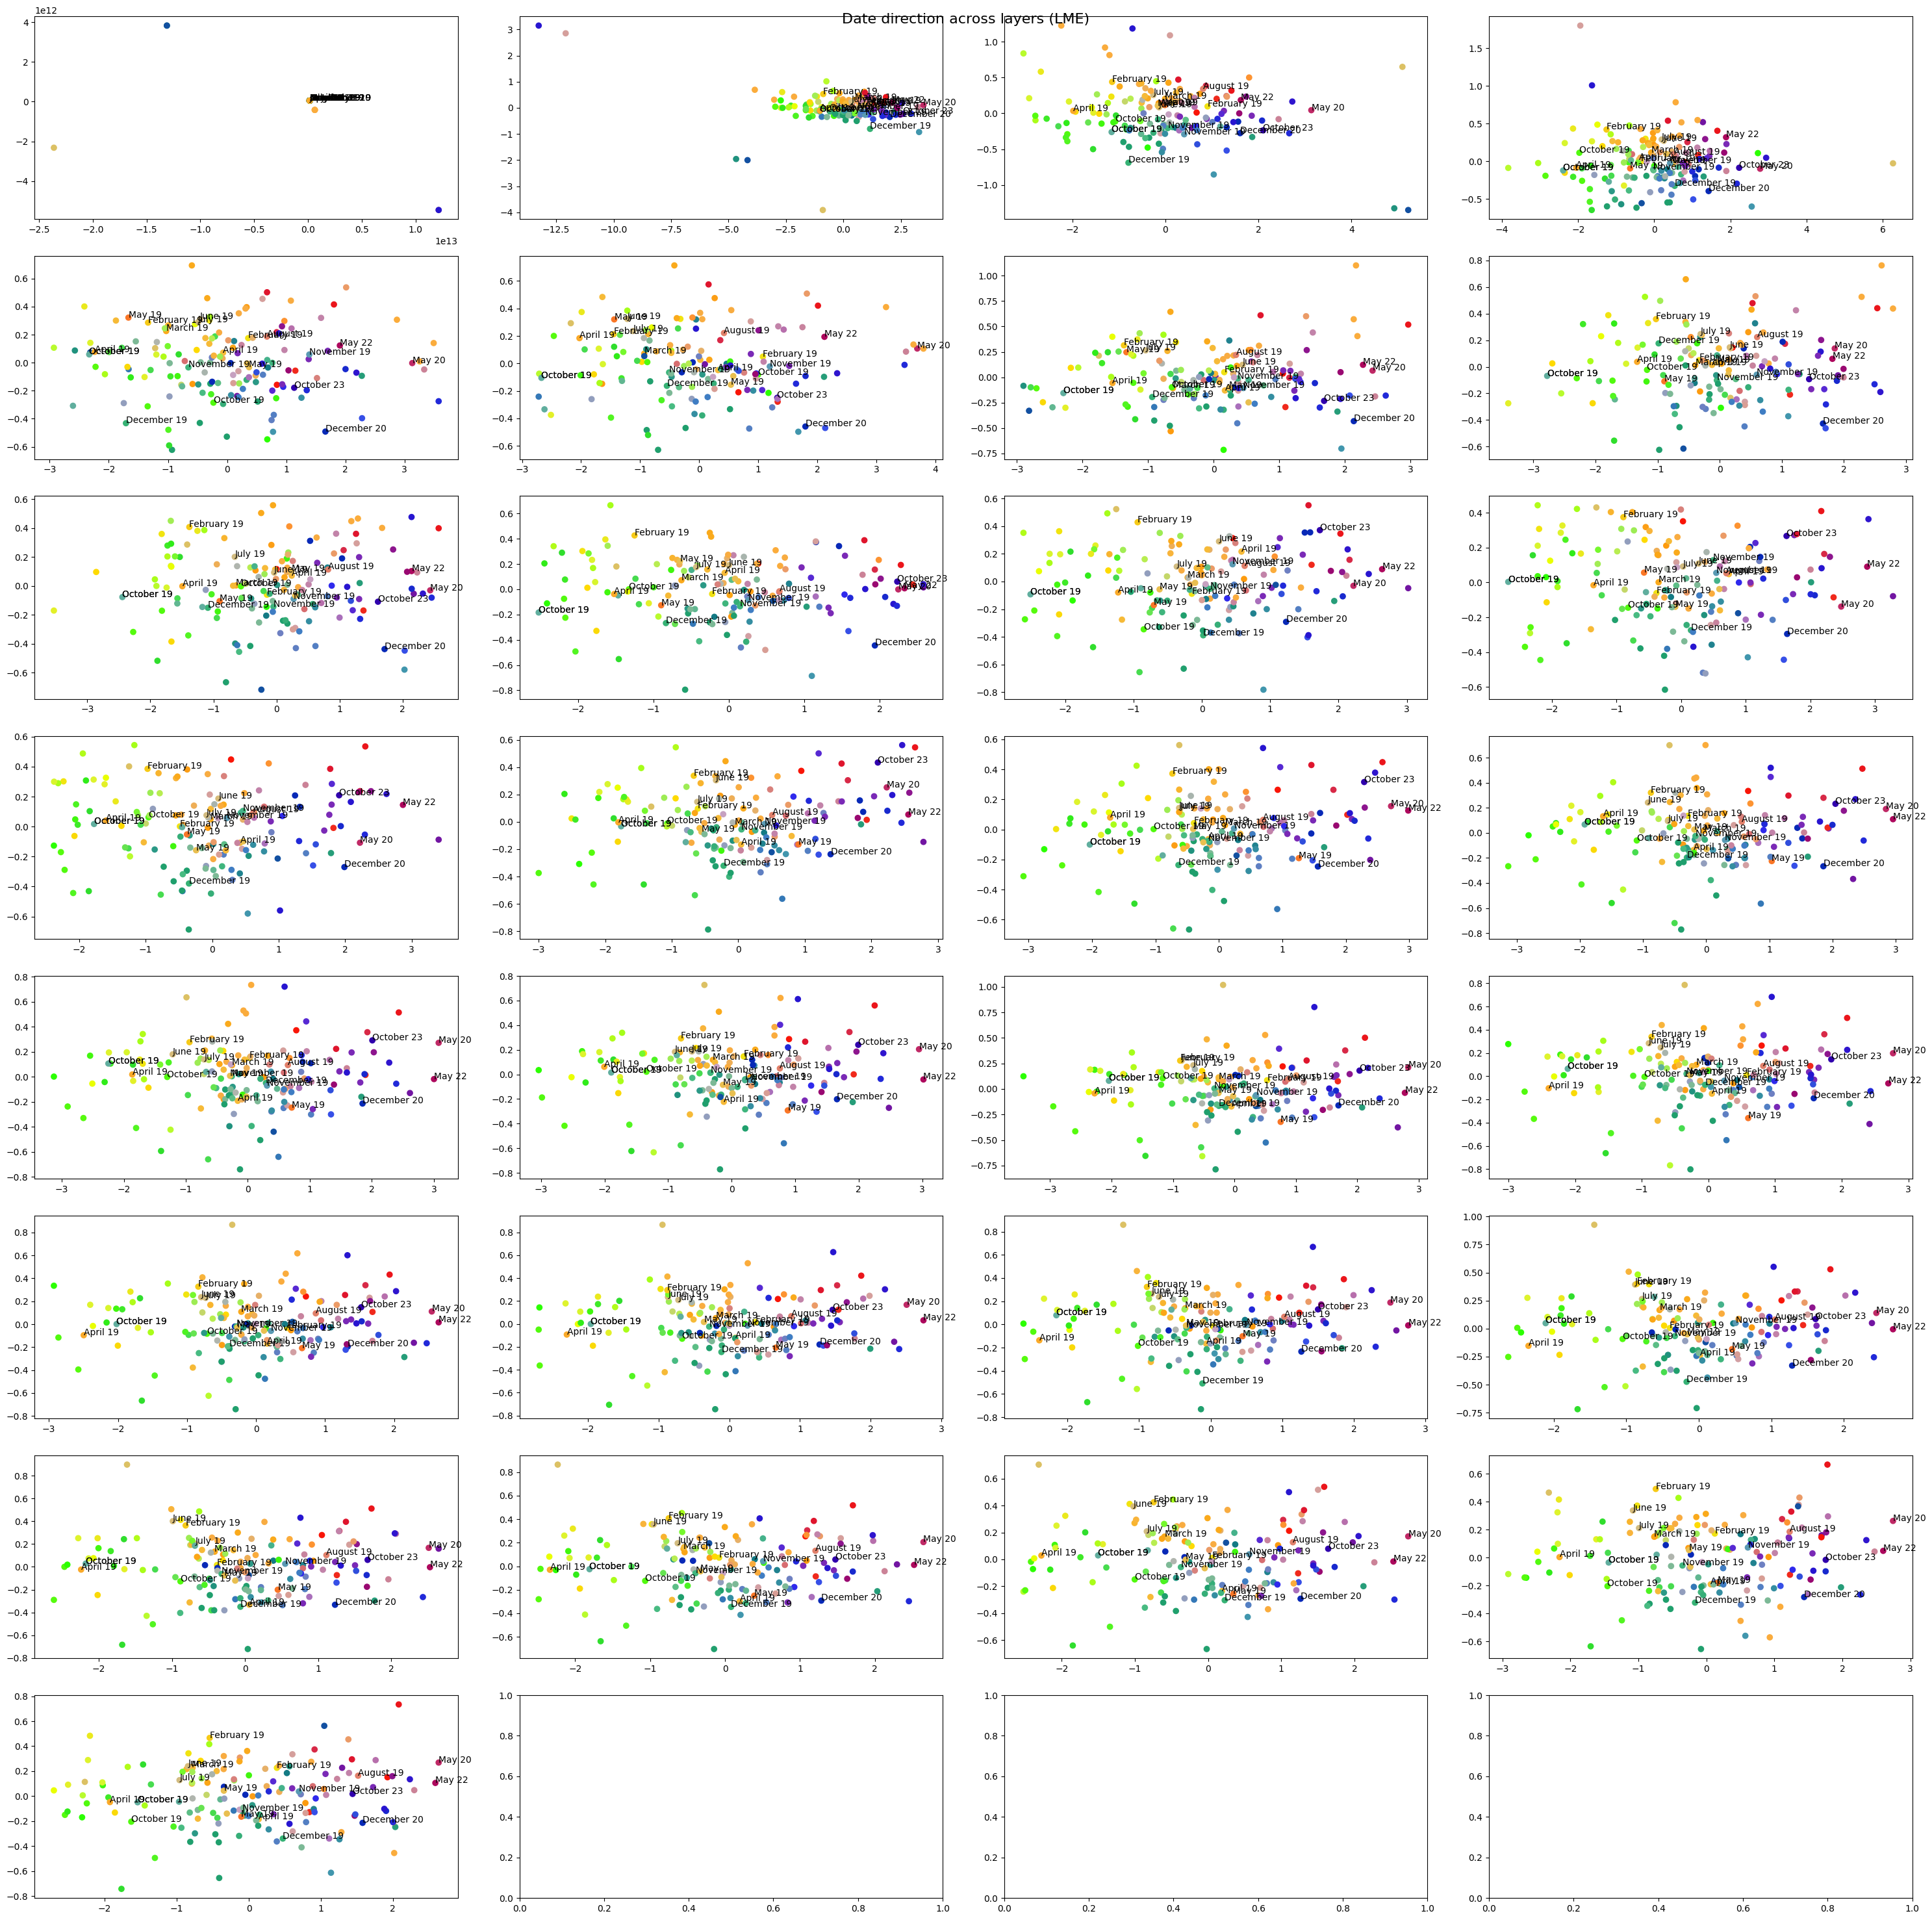

In [ ]:
# LME with double labels on all layers
from pycolormap_2d import ColorMap2DZiegler


lme_labels_train = joint_labels_train.to_numpy()
lme_labels_test = joint_labels_test.to_numpy()

# Min max scaling on training labels
cmap_labels_test = (lme_labels_test - lme_labels_train.min(axis=0)) / (lme_labels_train.max(axis=0) - lme_labels_train.min(axis=0))

cmap = ColorMap2DZiegler()
hues = [cmap(l1,l2) / 255.0 for l1, l2 in cmap_labels_test]

transformed_test_list = []
rnd_activations = []

# Generate 7 random indices
indices = np.random.choice(len(activations_test[0]), 20)

for i, layer in enumerate(activations_train):

    # Fit lme using train set and train labels
    lme = LinearMetricEmbedder(n_components=3, graph='euclidean')
    lme.fit(layer, lme_labels_train)

    # Transform test set
    transformed_test = lme.transform(activations_test[i])

    transformed_test_list.append(transformed_test)
    rnd_activations.append(transformed_test[indices])

    if 'correct_date' in test_set.columns:
        # rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_date'].strftime('%B %d'), axis=1)
        rnd_sent = test_set.iloc[indices].apply(lambda x: pd.to_datetime(x['correct_end_date']).strftime('%B %y'), axis=1)
        
    elif 'correct_time' in test_set.columns:
        # rnd_sent = test_set.iloc[indices].apply(lambda x: format_time(x['correct_time']), axis=1)
        rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_time'].strftime('%H:%M'), axis=1)
        # rnd_sent = pd.to_datetime(test_set['time']).iloc[indices].apply(lambda x: x.strftime('%H:%M'))

# Plotting
component1 = 0
component2 = 1


fig, axs = plt.subplots(int(np.ceil(len(transformed_test_list)/4)), 4, figsize=(30, 30))

for i in range(len(transformed_test_list)):
    ax = axs[i//4][i%4]
    # sns.scatterplot(x=transformed_test_list[i][:, component1],
    #                 y=transformed_test_list[i][:, component2],
    #                 hue=hues, ax=ax)
    axs[i//4][i%4].scatter(transformed_test_list[i][:, component1],
                    transformed_test_list[i][:, component2], color=hues)

    # ax.get_legend().set_visible(False)

    for j, txt in enumerate(rnd_sent):
        # Text must have a white outline
        ax.annotate(txt, (rnd_activations[i][j, component1], rnd_activations[i][j, component2]))
                        # fontsize=12, color='white', weight='bold',
                        # bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.3'))

plt.suptitle('Date direction across layers (LME)', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# UMAP with a discrete label on all layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
# pip install umap-learn

# Settings
component1 = 0
component2 = 1

# Extract discrete labels
if 'correct_date' in test_set.columns:
    discrete_labels_train = train_set['correct_date'].apply(lambda x: x.month)
    discrete_labels_test = test_set['correct_date'].apply(lambda x: x.month)
elif 'correct_time' in test_set.columns:
    discrete_labels_train = train_set['correct_time'].apply(lambda x: x.hour)
    discrete_labels_test = test_set['correct_time'].apply(lambda x: x.hour)

transformed_test_list = []
rnd_activations = []

# Generate 20 random indices
indices = np.random.choice(len(activations_test[0]), 20)

for i, layer in enumerate(activations_train):
    train_layer = layer
    dev_layer = activations_dev[i]
    test_layer = activations_test[i]

    # Fit UMAP using training set and discrete labels
    umap = UMAP(n_components=2, random_state=42)
    umap.fit(train_layer, y=discrete_labels_train)

    # Transform test set
    transformed_test = umap.transform(test_layer)

    transformed_test_list.append(transformed_test)
    rnd_activations.append(transformed_test[indices])

    # Prepare labels for annotated points
    if 'correct_date' in test_set.columns:
        rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_date'].strftime('%B %d'), axis=1)
    elif 'correct_time' in test_set.columns:
        rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_time'].strftime('%H:%M'), axis=1)

# Plotting
fig, axs = plt.subplots(int(np.ceil(len(transformed_test_list) / 4)), 4, figsize=(30, 30))

for i in range(len(transformed_test_list)):
    ax = axs[i // 4][i % 4]
    sns.scatterplot(
        x=transformed_test_list[i][:, component1],
        y=transformed_test_list[i][:, component2],
        hue=labels_test,
        ax=ax,
        palette='twilight_shifted'
    )
    ax.get_legend().set_visible(False)

    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[i][j, component1], rnd_activations[i][j, component2]))

plt.suptitle('Date/Time direction across layers (UMAP)', fontsize=16)
plt.tight_layout()
plt.show()


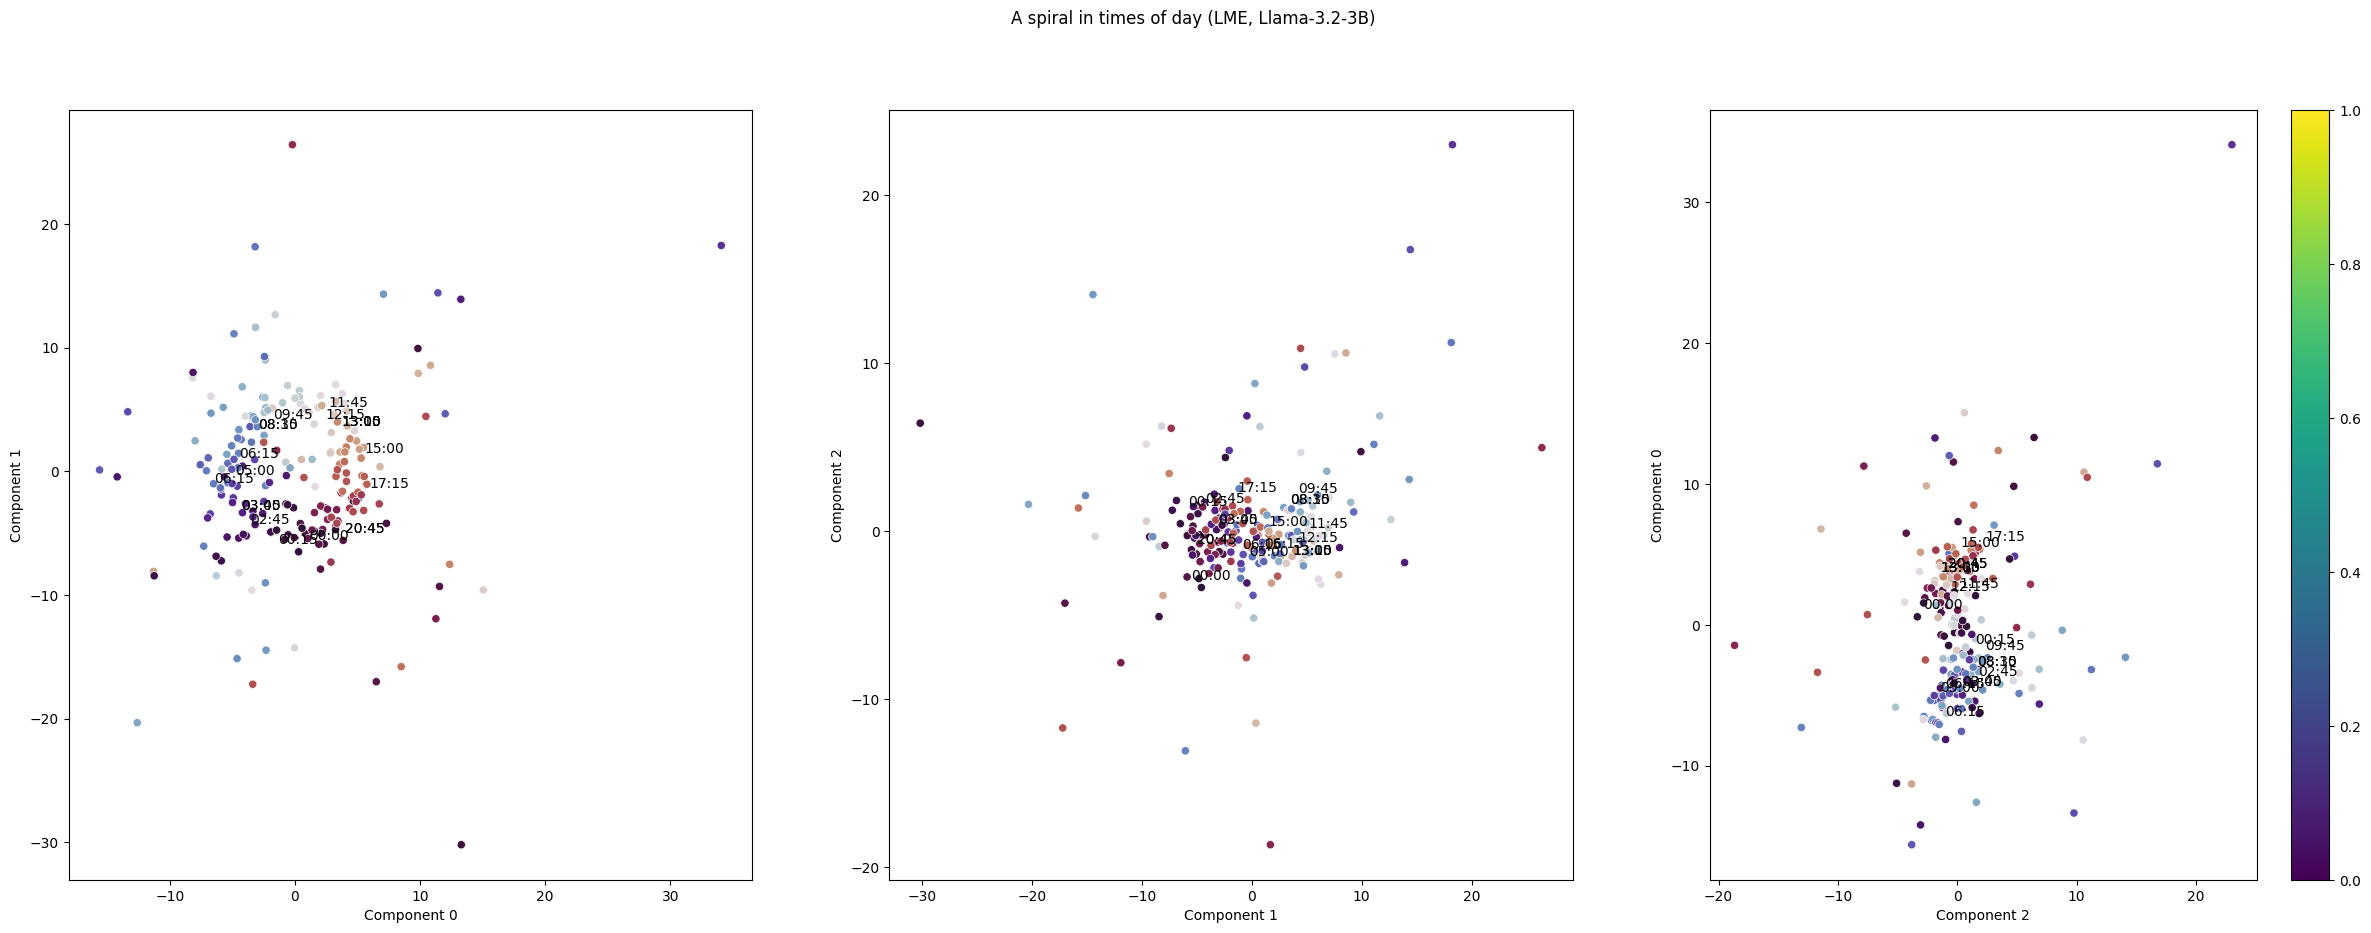

In [ ]:
# LME (LinearMetricEmbedder) with discrete label

best_layer = 7

if 'correct_date' in test_set.columns:
    discrete_labels_train = train_set['correct_date'].apply(lambda x: x.month).to_numpy()
    discrete_labels_test = test_set['correct_date'].apply(lambda x: x.month).to_numpy()
elif 'correct_time' in test_set.columns:
    discrete_labels_train = train_set['correct_time'].apply(lambda x: x.hour).to_numpy()
    discrete_labels_test = test_set['correct_time'].apply(lambda x: x.hour).to_numpy()

lme = LinearMetricEmbedder(n_components=3, graph='circular')
lme.fit(activations_train[best_layer], discrete_labels_train)


lme_test = lme.transform(activations_test[best_layer])

# Generate 10 indices
indices = np.random.choice(len(activations_test[best_layer]), 20)
# Get sentences and acivations
if 'sentence' in test_set.columns:
    rnd_sent = test_set['sentence'].iloc[indices]
elif 'correct_date' in test_set.columns:
    rnd_sent = test_set['correct_date'].iloc[indices]
    # Parse as month day
    rnd_sent = pd.to_datetime(rnd_sent).dt.strftime('%B %d')
elif 'correct_time' in test_set.columns:
    rnd_sent = test_set['correct_time'].iloc[indices]
    # Parse as hour minute
    rnd_sent = pd.to_datetime(rnd_sent).dt.strftime('%H:%M')
rnd_activations = activations_test[best_layer][indices]
# Transform activations
rnd_activations = lme.transform(rnd_activations)

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i, ax in enumerate(axs):
    # sns.scatterplot(x=pls_train[:, i%3], y=pls_train[:, (i+1)%3], hue=train_set['label'], ax=ax, palette='viridis')
    sns.scatterplot(x=lme_test[:, i%3], y=lme_test[:, (i+1)%3], hue=labels_test, ax=ax, palette='twilight_shifted')
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i%3], rnd_activations[j, (i+1)%3]))
    ax.set_xlabel(f'Component {i%3}')
    ax.set_ylabel(f'Component {(i+1)%3}')
    ax.get_legend().set_visible(False)


fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs[2])
# Set title
plt.suptitle('A spiral in times of day (LME, Llama-3.2-3B)')
plt.show()


In [ ]:
# Isomap with a continuous label on all layers

transformed_test_list = []
rnd_activations = []

# Generate 7 random indices
indices = np.random.choice(len(activations_test[0]), 7)

for i, layer in enumerate(activations_train):
    # nm = Normalizer()
    # nm.fit(layer)

    # norm_train = nm.transform(layer)
    # norm_dev = nm.transform(activations_dev[i])
    # norm_test = nm.transform(activations_test[i])

    # Apply Isomap to normalized test data
    isomap = Isomap(n_components=5, n_neighbors=300)
    isomap.fit(activations_train[i])
    transformed_test = isomap.transform(activations_test[i])
    
    transformed_test_list.append(transformed_test)
    rnd_activations.append(transformed_test[indices])

    if 'correct_date' in test_set.columns:
        rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_date'].strftime('%B %d'), axis=1)
    elif 'correct_time' in test_set.columns:
        rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_time'].strftime('%H:%M'), axis=1)

In [ ]:
# Plotting
component1 = 0
component2 = 4

fig, axs = plt.subplots(int(np.ceil(len(transformed_test_list)/4)), 4, figsize=(30, 30))

for i in range(len(transformed_test_list)):
    ax = axs[i//4][i%4]
    sns.scatterplot(x=transformed_test_list[i][:, component1],
                    y=transformed_test_list[i][:, component2],
                    hue=labels_test, ax=ax, palette='viridis')
    ax.get_legend().set_visible(False)

    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[i][j, component1], rnd_activations[i][j, component2]))

plt.suptitle('Date direction across layers (Isomap)', fontsize=16)
plt.tight_layout()
plt.show()

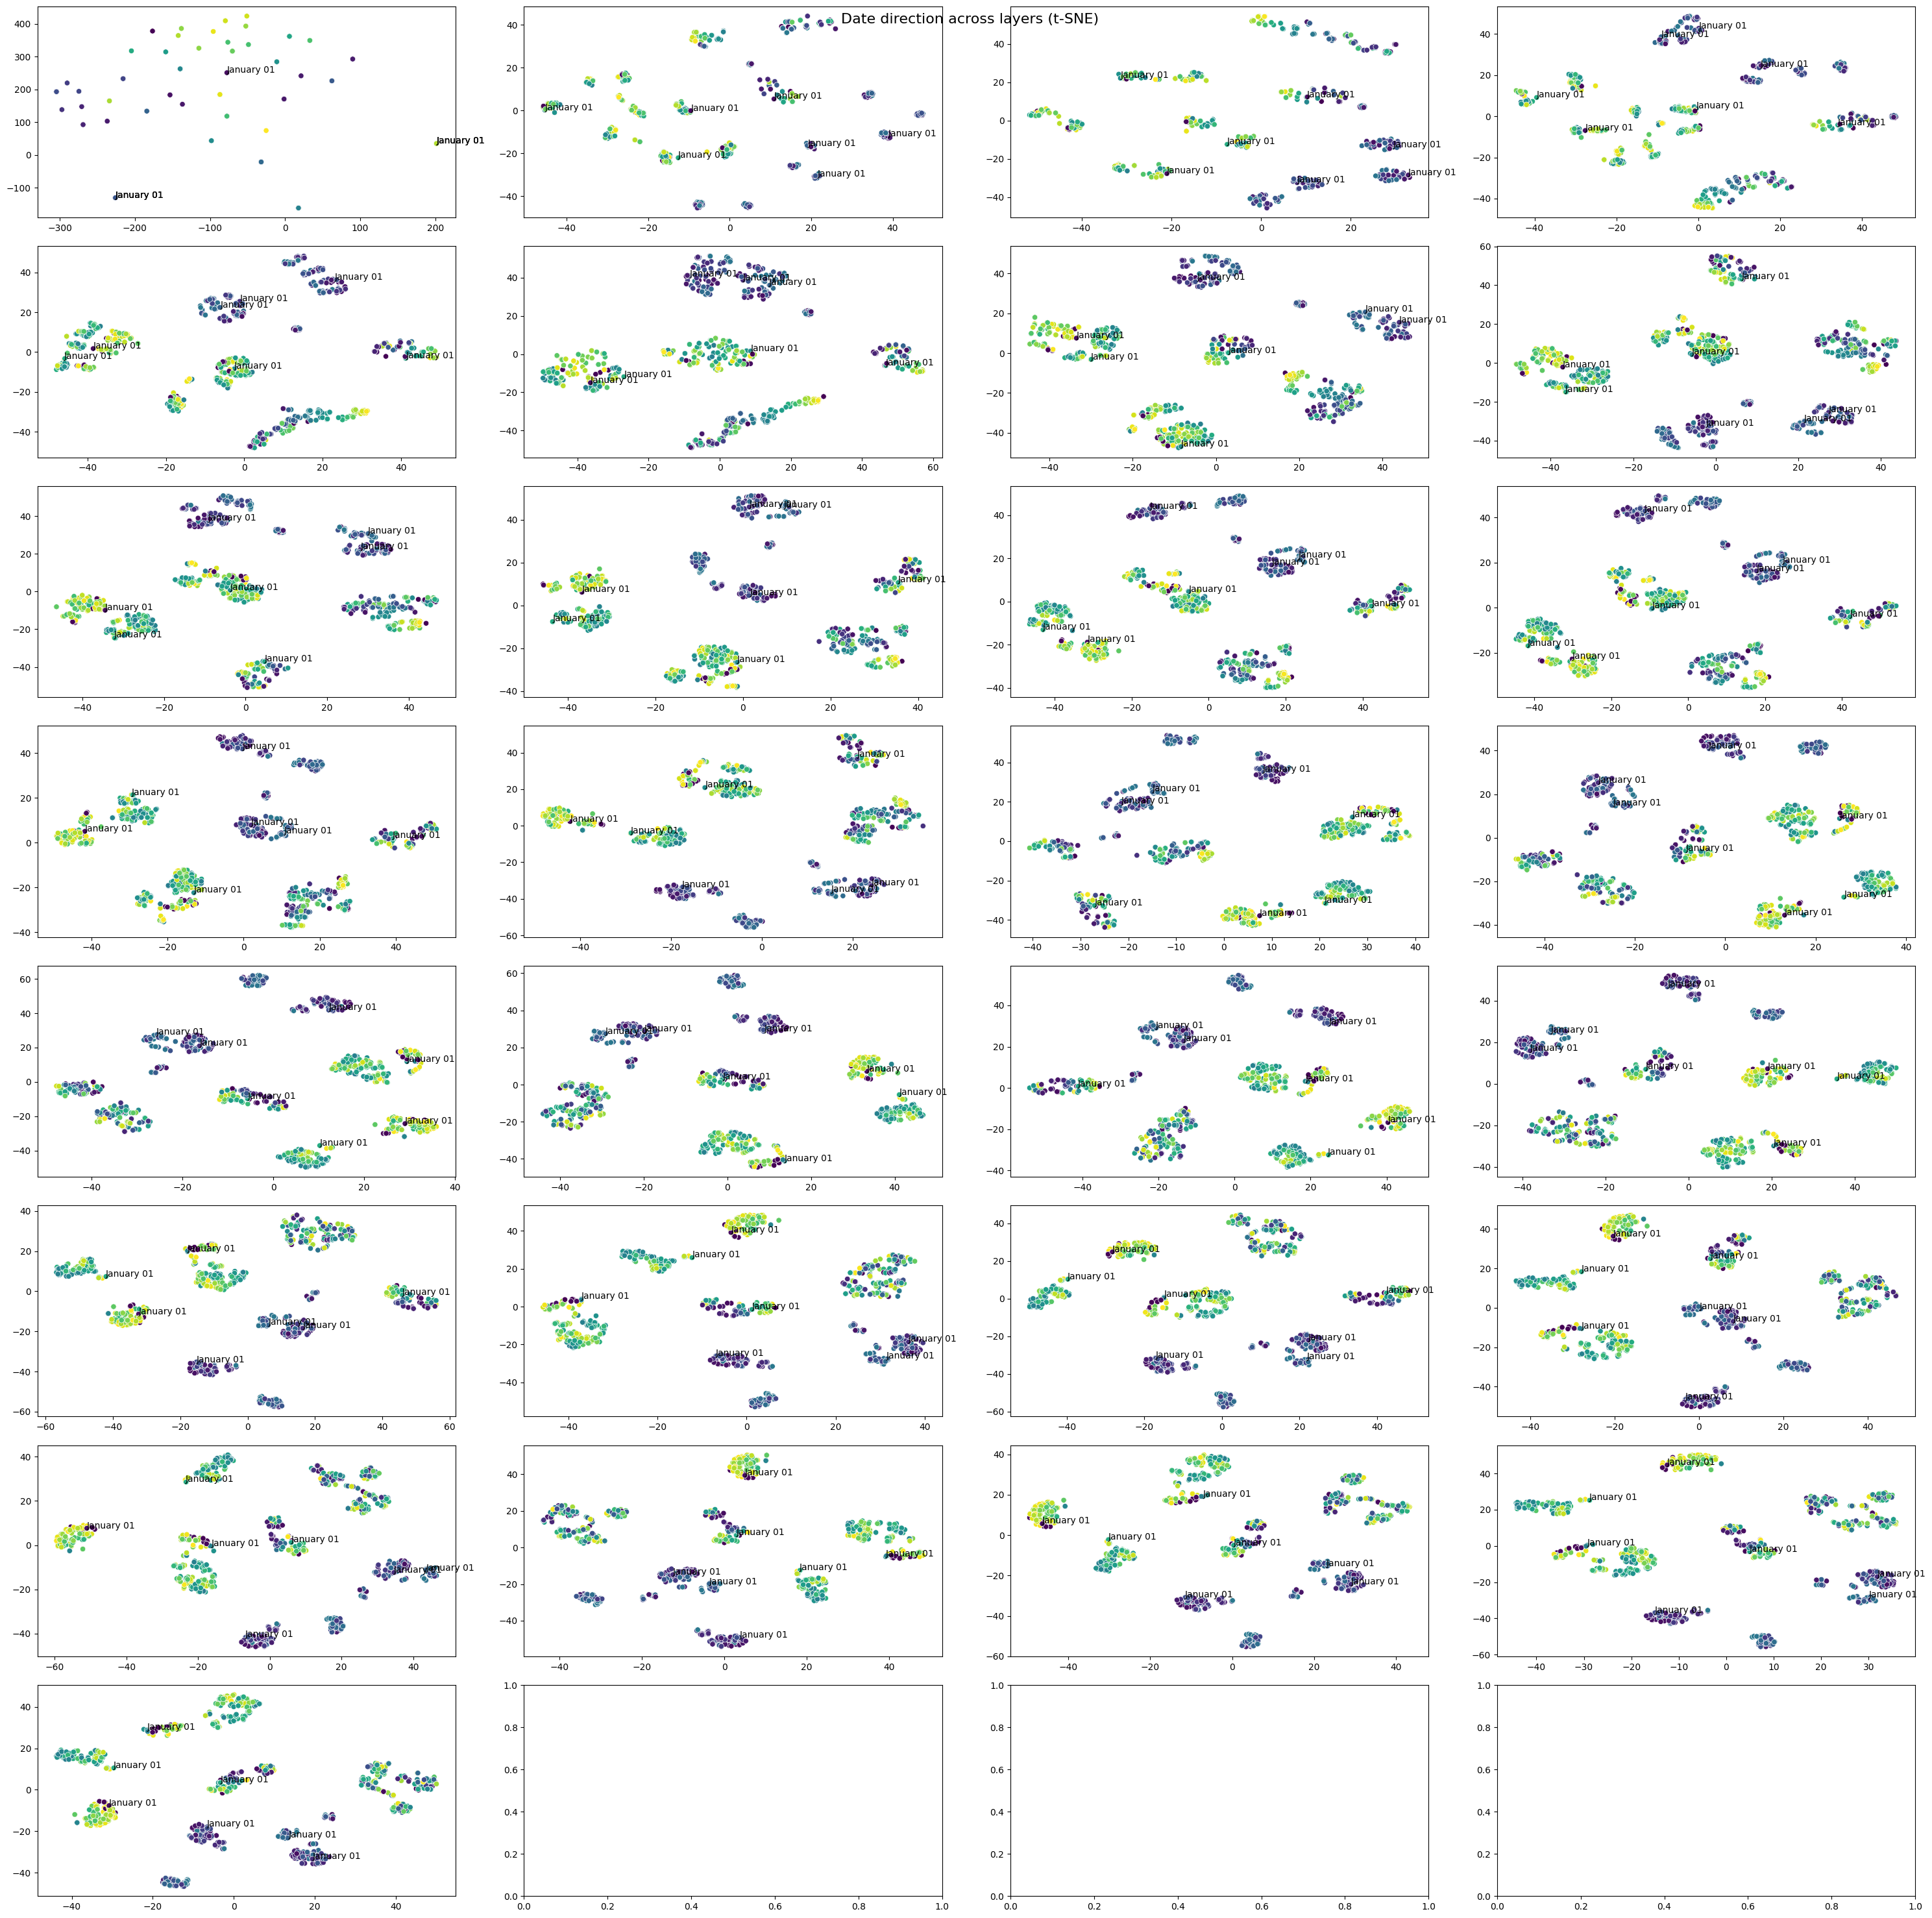

In [ ]:
# TSNE with a continuous label on all layers
component1 = 0
component2 = 1

transformed_test_list = []
rnd_activations = []

# Generate 7 random indices
indices = np.random.choice(len(activations_test[0]), 7)

for i, layer in enumerate(activations_train):
    nm = Normalizer()
    nm.fit(layer)

    norm_train = nm.transform(layer)
    norm_dev = nm.transform(activations_dev[i])

    # Now apply t-SNE to test data for visualization
    norm_test = nm.transform(activations_test[i])
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca')
    transformed_test = tsne.fit_transform(norm_test)

    transformed_test_list.append(transformed_test)
    rnd_activations.append(transformed_test[indices])

    rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_time'].strftime('%B %d'), axis=1)


# Plotting
fig, axs = plt.subplots(int(np.ceil(len(transformed_test_list)/4)), 4, figsize=(30, 30))

for i in range(len(transformed_test_list)):
    ax = axs[i//4][i%4]
    sns.scatterplot(x=transformed_test_list[i][:, component1],
                    y=transformed_test_list[i][:, component2],
                    hue=labels_test, ax=ax, palette='viridis')
    ax.get_legend().set_visible(False)

    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[i][j, component1], rnd_activations[i][j, component2]))

plt.suptitle('Date direction across layers (t-SNE)', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# PCA with discrete classes

best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    if i / len(activations_train) < 0.25 or i / len(activations_train) > 0.75:
        continue
    pca = PCA(n_components=2)
    pca.fit(layer)
    transformed_train = pca.transform(layer)
    transformed_dev = pca.transform(activations_test[i])
    score = np.corrcoef(transformed_dev[:, 0], test_set['label'])[0, 1]  # Correlation as a proxy for score
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

# best_layer = 6 # Override best layer

pca = PCA(n_components=3)
pca.fit(activations_train[best_layer])
pca_all = pca.transform(all_activations[best_layer])

# Generate 10 indices
indices = np.random.choice(len(all_activations[best_layer]), 20)
# Get sentences and activations
rnd_sent = df['sentence'].iloc[indices]
rnd_activations = all_activations[best_layer][indices]
# Transform activations
rnd_activations = pca.transform(rnd_activations)

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
classes = df['class'].unique()
palette = {classes[i]: sns.color_palette()[i] for i in range(len(classes))}
print(palette)
for i, ax in enumerate(axs):
    sns.scatterplot(x=pca_all[:, i % 3], y=pca_all[:, (i + 1) % 3], hue=all_classes, ax=ax, palette=palette)
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i % 3], rnd_activations[j, (i + 1) % 3]))
    ax.set_xlabel(f'Component {i % 3}')
    ax.set_ylabel(f'Component {(i + 1) % 3}')

# Set title
plt.suptitle('Date direction for GPT-2 (PCA)')
plt.show()

In [ ]:
# PCA with a continuous label and evaluation on verbs - Doesnt work

best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    if i / len(activations_train) < 0.25 or i / len(activations_train) > 0.75:
        continue
    pca = PCA(n_components=2)
    pca.fit(layer)
    transformed_train = pca.transform(layer)
    transformed_dev = pca.transform(activations_test[i])
    score = np.corrcoef(transformed_dev[:, 0], test_set['label'])[0, 1]  # Correlation as a proxy for score
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

# best_layer = 18 # Override best layer

pca = PCA(n_components=3)
pca.fit(activations_train[best_layer])
pca_all = pca.transform(all_activations[best_layer])

# Generate 10 indices
indices = np.random.choice(len(all_activations[best_layer]), 20)
# Get sentences and activations
rnd_sent = df['sentence'].iloc[indices]
rnd_activations = all_activations[best_layer][indices]
# Transform activations
rnd_activations = pca.transform(rnd_activations)

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i, ax in enumerate(axs):
    sns.scatterplot(x=pca_all[:, i % 3], y=pca_all[:, (i + 1) % 3], hue=all_labels, ax=ax, palette='viridis')
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i % 3], rnd_activations[j, (i + 1) % 3]))
    ax.set_xlabel(f'Component {i % 3}')
    ax.set_ylabel(f'Component {(i + 1) % 3}')
    ax.get_legend().set_visible(False)

fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs[2])
# Set title
plt.suptitle('Date direction for GPT-2 (PCA)')
plt.show()

In [ ]:
# PLS regression with two classes

best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    if i/len(activations_train) < 0.25 or i/len(activations_train) > 0.75:
        continue
    pls = PLSRegression(n_components=2)
    pls.fit(layer, train_set['label'])
    score = pls.score(activations_test[i], test_set['label'])
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

best_layer = 10 # Override best layer


pls = PLSRegression(n_components=3)
pls.fit(activations_train[best_layer], train_set['label'])

pls_train = pls.transform(activations_train[best_layer])
pls_test = pls.transform(activations_test[best_layer])

# Generate 10 indices
indices = np.random.choice(len(all_activations[best_layer]), 10)
# Get sentences and acivations
rnd_sent = df['sentence'].iloc[indices]
rnd_activations = all_activations[best_layer][indices]
# Transform activations
rnd_activations = pls.transform(rnd_activations)

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i, ax in enumerate(axs):
    sns.scatterplot(x=pls_train[:, i%3], y=pls_train[:, (i+1)%3], hue=train_set['label'], ax=ax, palette='viridis')
    sns.scatterplot(x=pls_test[:, i%3], y=pls_test[:, (i+1)%3], hue=test_set['label'], ax=ax, palette='viridis')
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i%3], rnd_activations[j, (i+1)%3]))
    ax.set_xlabel(f'Component {i%3}')
    ax.set_ylabel(f'Component {(i+1)%3}')
    ax.get_legend().set_visible(False)


fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs[2])
# Set title
plt.suptitle('Date direction for gemma-2-2b')
plt.show()

### Structure Learning

This section tries to deduce a structure from a given set of points

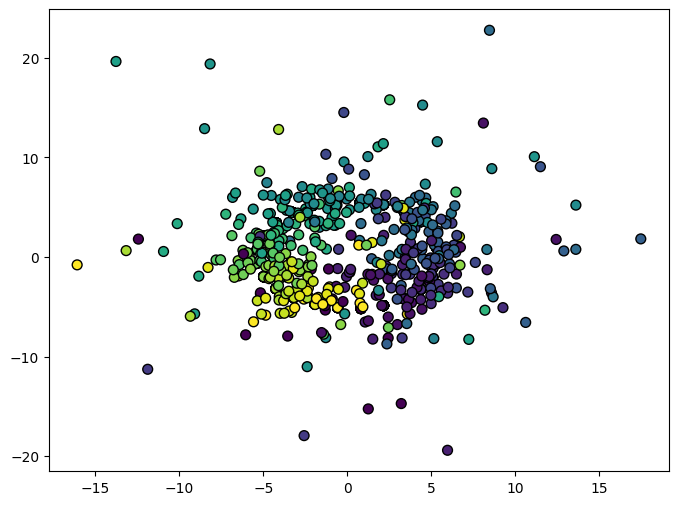

Best score: 0.9771 for dimensions (283, 3039):  16%|█▌        | 499/3072 [02:30<12:56,  3.31it/s]


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import entropy
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.linalg import eigh
from tqdm import tqdm
from sklearn_som.som import SOM

class LinearMetricEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2, graph='trivial'):
        self.n_components = n_components
        self.graph = graph
        self.W_ = None
        self.mean_ = None

    def _compute_ideal_distances(self, y):
        n = len(y)
        d_ij = np.zeros((n, n))

        if self.graph == 'trivial':
            for i in range(n):
                for j in range(n):
                    d_ij[i, j] = 0.0 if y[i] == y[j] else 1.0
        elif self.graph == 'euclidean':
            for i in range(n):
                for j in range(n):
                    d_ij[i, j] = np.linalg.norm(y[i] - y[j])
        elif self.graph == 'circular':
            max_y = np.max(y)
            for i in range(n):
                for j in range(n):
                    d_ij[i, j] = min(np.abs(y[i] - y[j]), max_y + 1 - np.abs(y[i] - y[j]))

        elif callable(self.graph):
            d_ij = self.graph(y)
        else:
            raise ValueError("Invalid graph specification.")
        
        return d_ij

    def _classical_mds(self, D):
        D2 = D ** 2
        n = D2.shape[0]
        H = np.eye(n) - np.ones((n, n)) / n
        B = -0.5 * H @ D2 @ H
        eigvals, eigvecs = eigh(B)
        idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[idx][:self.n_components]
        eigvecs = eigvecs[:, idx][:, :self.n_components]
        Y = eigvecs * np.sqrt(np.maximum(eigvals, 0))
        return Y

    def fit(self, X, y):
        X = np.asarray(X)
        D = self._compute_ideal_distances(y)
        Y = self._classical_mds(D)
        self.mean_ = X.mean(axis=0)
        X_centered = X - self.mean_
        Y_centered = Y - Y.mean(axis=0)
        self.W_ = Y_centered.T @ np.linalg.pinv(X_centered.T)
        return self

    def transform(self, X):
        X = np.asarray(X)
        X_centered = X - self.mean_
        return (self.W_ @ X_centered.T).T
    
    def normalized_entropy(self, y):
        p = np.bincount(y) / len(y)
        ent = entropy(p)
        return ent

    def score(self, X, y):
        if self.W_ is None:
            raise RuntimeError("Model must be fit before scoring.")
        D_true = self._compute_ideal_distances(y)
        X_proj = self.transform(X)
        n = X_proj.shape[0]
        D_pred = np.linalg.norm(X_proj[:, np.newaxis, :] - X_proj[np.newaxis, :, :], axis=-1)
        mask = np.triu(np.ones((n, n), dtype=bool), k=1)
        stress = np.sum((D_pred[mask] - D_true[mask]) ** 2)
        denom = np.sum(D_true[mask] ** 2)
        return 1 - stress / denom - self.normalized_entropy(y) if denom > 0 else -np.inf


def circularity_score(points_2d):
    """
    Estimate how well a 2D point cloud approximates a circle.

    Parameters:
        points_2d (ndarray): Shape (N, 2), 2D point cloud.

    Returns:
        dict with center, radius, score, and radius statistics.
    """
    if points_2d.shape[1] != 2:
        raise ValueError("Input points must be 2D.")
    x = points_2d[:, 0]
    y = points_2d[:, 1]

    # Fit circle: (x - a)^2 + (y - b)^2 = r^2
    A = np.c_[2*x, 2*y, np.ones_like(x)]
    b = x**2 + y**2
    sol = np.linalg.lstsq(A, b, rcond=None)[0]

    center = sol[:2]
    r_est = np.sqrt(sol[2] + center @ center)

    # Distances to estimated center
    dists = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r_mean = np.mean(dists)
    r_std = np.std(dists)

    # Score: closer to 1 means more circular
    score = 1 - (r_std / r_mean)
    return score

def mutate(y, k=3, mutation_distance=5, mutation_rate=0.1):
    """
    Mutate labels by either increasing, decreasing them.

    Parameters:
        y : array of labels
        k : int, number of clusters
    """
    rng = np.random.default_rng()
    y_new = y.copy()
    for i in range(len(y)):
        randn = rng.random()
        if randn < mutation_rate:
            y_new[i] = (y[i] + rng.integers(1, mutation_distance)) % k
        elif 1 - randn < mutation_rate:
            y_new[i] = (y[i] -  rng.integers(1, mutation_distance)) % k
    return y_new

from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
import numpy as np
from collections import Counter
import numpy as np

def balance_labels(X, labels, k):
    counts = Counter(labels)
    desired = len(labels) // k
    over = [i for i, c in counts.items() if c > desired]
    under = [i for i in range(k) if counts[i] < desired]

    # Reassign from over to under using nearest-centroid
    centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    for i in over:
        idxs = np.where(labels == i)[0]
        dists = np.linalg.norm(X[idxs][:, None, :] - centroids[under][None, :, :], axis=-1)
        reassigned = 0
        for j in np.argsort(dists, axis=0).flatten():
            if reassigned >= (counts[i] - desired): break
            new_label = under[np.argmin(dists[j])]
            labels[idxs[j]] = new_label
            reassigned += 1
    return labels


def circular_spectral_labels(X_proj, k, n_neighbors=10):
    # Step 1: Build symmetric kNN graph for affinity
    A = kneighbors_graph(X_proj, n_neighbors=n_neighbors, mode='connectivity', include_self=False)
    A = 0.5 * (A + A.T)

    # Step 2: Spectral clustering on this affinity graph
    spectral = SpectralClustering(
        n_clusters=k,
        affinity='precomputed',
        assign_labels='kmeans',  # can also use 'discretize'
        random_state=42
    )
    raw_labels = spectral.fit_predict(A.toarray())

    # Step 3: Reorder labels based on circular structure
    circular_labels = reorder_labels(X_proj, raw_labels, k=k)

    return circular_labels


def circular_manifold_labels(X_proj, k):
    # Use TSNE to project the data into 2D
    tsne = TSNE(n_components=3, random_state=42)
    X_proj_2d = tsne.fit_transform(X_proj)
    # Compute the pairwise distances
    dists = np.linalg.norm(X_proj_2d[:, None, :] - X_proj_2d[None, :, :], axis=-1)
    # Compute the pairwise angles
    angles = np.arctan2(X_proj_2d[:, 1], X_proj_2d[:, 0])
    # Sort the angles
    sorted_indices = np.argsort(angles)
    # Create a mapping from the sorted indices to the original labels
    relabel_map = {old: new for new, old in enumerate(sorted_indices)}
    # Reassign the labels based on the sorted indices
    circular_labels = np.array([relabel_map[label] for label in range(len(X_proj_2d))])
    # Reorder the labels to be in the range [0, k-1]
    circular_labels = np.array([label % k for label in circular_labels])
    return circular_labels



def reorder_labels(X_proj, y, k=3):
    centroids = np.array([X_proj[y == i].mean(axis=0) for i in range(k)])
    pcs = PCA(n_components=2).fit_transform(centroids)
    angles = np.arctan2(pcs[:, 1], pcs[:, 0])
    sort_order = np.argsort(angles)
    relabel_map = {old: new for new, old in enumerate(sort_order)}
    circular_labels = np.array([relabel_map[label] for label in y])
    return circular_labels



def optimize_labels(X, k=3, n_iter=10, lambda_=0.5, random_state=0, graph='trivial'):
    """
    Alternating optimization to infer labels y and projection W.
    """
    rng = np.random.default_rng(random_state)
    # y = KMeans(n_clusters=k, random_state=random_state).fit_predict(X)
    y = circular_manifold_labels(X, k=k)
    best_y = y.copy()
    best_score = -np.inf
    model = LinearMetricEmbedder(n_components=10, graph=graph)

    pbar = tqdm(range(n_iter))
    for i in pbar:
        model.fit(X, y)
        X_proj = model.transform(X)

        # Try new y by re-clustering in projected space
        # y_new = KMeans(n_clusters=k, random_state=rng.integers(0, 1e5)).fit_predict(X_proj)
        # y_new = SOM(m=20, n=20, dim=X_proj.shape[1], lr=0.1).fit_predict(X_proj)
        # y_new = mutate(y, k=k, mutation_distance=5, mutation_rate=0.1)
        y_new = circular_spectral_labels(X_proj, k=k, n_neighbors=10)
        # y_new = balance_labels(X_proj, y_new, k=k)
        # y_new = reorder_labels(X_proj, y_new, k=k)
        # y_new = circular_manifold_labels(X_proj, k=k)

        # Compute score
        model.fit(X, y_new)
        score = model.score(X, y_new)
        p = np.bincount(y_new, minlength=k) / len(y_new)
        ent = entropy(p)
        total_score = score - lambda_ * ent

        # Print total score in tqdm
        pbar.set_description(f"Score: {total_score:.4f}, Entropy: {ent:.4f}")

        if total_score > best_score:
            best_score = total_score
            best_y = y_new.copy()

        y = y_new

    model.fit(X, best_y)
    return best_y, model


def find_circular_dimensions(X):
    """
    Score the circularity of each pair of dimensions in the data.
    """
    best_score = -np.inf
    best_indices = None
    pbar = tqdm(range(X.shape[1]))
    for i in pbar:
        for j in range(i + 1, X.shape[1]):
            # Project to 2D
            X_slice = X[:, [i, j]]

            # Compute circularity score
            score = circularity_score(X_slice)

            if score > best_score:
                best_score = score
                best_indices = (i, j)
            
        pbar.set_description(f"Best score: {best_score:.4f} for dimensions {best_indices}")
    print(f"Best circularity score: {best_score:.4f} for dimensions {best_indices}")
    return X[:, best_indices], best_indices
            

# Generate data
X_train, y_train = activations_train[10], discrete_labels_train
X_test, y_test = activations_test[10], discrete_labels_test


# X, y_true = np.random.randn(len(discrete_labels_test), 1000), discrete_labels_test 

# Sample only 100 point and labels at random
# indices = np.random.choice(len(X_train), 200, replace=False)
# X_train = X_train[indices]
# y_train = y_train[indices]

# Print an initial plot with true labels in a supervised way with LME
lme = LinearMetricEmbedder(n_components=2, graph='circular')
lme.fit(X_train, y_train)
X_proj = lme.transform(X_test)

# lda = LinearDiscriminantAnalysis(n_components=2)
# lda.fit(X, y_true)
# X_proj = lda.transform(X)

# Plot the projected data
plt.figure(figsize=(8, 6))
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y_test, cmap='viridis', edgecolor='k', s=50)
plt.show()
plt.close


# X, y_true = generate_square_clusters(n_per_cluster=50, noise_std=0.05)

# labels, model = optimize_labels(X_test, k=20, n_iter=10, lambda_=1, graph='circular')
# X_proj = model.transform(X_test)

X_proj, best_indices = find_circular_dimensions(X_test)
labels = np.zeros(X_proj.shape[0])

# Plot side by side true labels and inferred labels
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(X_proj[:, 0], X_proj[:, 1], c=y_test, cmap='viridis', edgecolor='k', s=50)
axs[0].set_title('True Labels')
axs[1].scatter(X_proj[:, 0], X_proj[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)
axs[1].set_title('Inferred Labels')
plt.show()

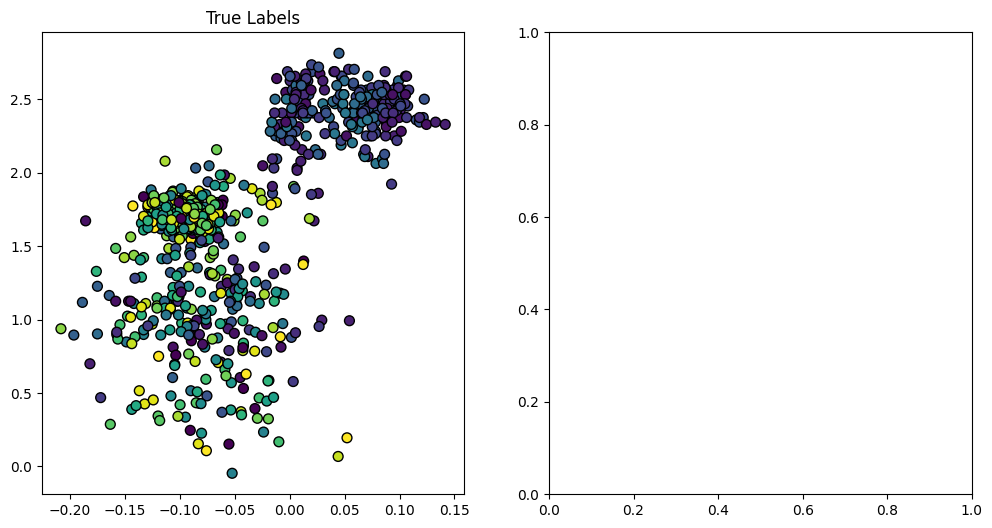

In [ ]:
# Plot side by side true labels and inferred labels
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(X_test[:, 283], X_test[:, 3039], c=y_test, cmap='viridis', edgecolor='k', s=50)
axs[0].set_title('True Labels')
# axs[1].scatter(X_proj[:, 0], X_proj[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)
# axs[1].set_title('Inferred Labels')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


class LinearMetricEmbedderTorch(nn.Module):
    def __init__(self, input_size, n_components=2, graph='trivial'):
        """
        Parameters:
            n_components: int
                Target embedding dimension.
            graph: str or callable
                If 'trivial', d_ij = 0 if y_i == y_j else 1.
                If callable, should return a (n x n) ideal distance matrix given y.
        """
        super().__init__()
        self.n_components = n_components
        self.graph = graph
        self.W = nn.Parameter(torch.randn(n_components, input_size))
        self.cle = CircularLabelEstimator(n=input_size)
        t = torch.linspace(0, 1, 100).unsqueeze(1)  # (100, 1)
        self.t = t.to(device)

    def _compute_ideal_distances(self, y):
        n = y.shape[0]
        y = y.view(-1)
        D = torch.zeros(n, n, device=y.device)

        if self.graph == 'trivial':
            D = (y.unsqueeze(0) != y.unsqueeze(1)).float()
        elif self.graph == 'euclidean':
            D = torch.cdist(y.unsqueeze(1).float(), y.unsqueeze(1).float(), p=2)
        elif self.graph == 'circular':
            max_y = self.t.shape[0] 
            diff = torch.abs(y.unsqueeze(0) - y.unsqueeze(1))
            D = torch.minimum(diff, max_y - diff).float()
        elif callable(self.graph):
            D = self.graph(y)
        else:
            raise ValueError("Invalid graph specification.")

        return D

    def _classical_mds(self, D):
        n = D.shape[0]
        D2 = D ** 2
        H = torch.eye(n, device=D.device) - torch.ones(n, n, device=D.device) / n
        B = -0.5 * H @ D2 @ H

        # eigen-decomposition
        eigvals, eigvecs = torch.linalg.eigh(B)
        idx = torch.argsort(eigvals, descending=True)
        eigvals = eigvals[idx][:self.n_components]
        eigvecs = eigvecs[:, idx][:, :self.n_components]
        eigvals_clipped = torch.clamp(eigvals, min=0.0)

        Y = eigvecs * torch.sqrt(eigvals_clipped)
        return Y
    
    def normalized_entropy(self, y):
        y = y.flatten()
        counts = torch.bincount(y, minlength=self.t.shape[0] + 1).float()
        probs = counts / counts.sum()
        probs = probs[probs > 0]  # avoid log(0)

        entropy = -torch.sum(probs * torch.log(probs))
        max_entropy = torch.log(torch.tensor(len(counts), dtype=torch.float))

        return (entropy / max_entropy).item()
         

    def forward(self, X):
        """
        Fit and apply the linear transformation to X, returning (transformed_X, score).
        """
        X = X.float()
        centroids = self.cle(self.t)

        y_hat_idx = torch.argmin(torch.cdist(X , centroids , p=2), dim=1)

        D = self._compute_ideal_distances(y_hat_idx)
        # Y = self._classical_mds(D)

        X_centered = X - X.mean(dim=0)
        # Y_centered = Y - Y.mean(dim=0)

        # Least squares: solve W @ X_centered.T ≈ Y_centered.T
        # W = torch.linalg.lstsq(X_centered.T, Y_centered.T).solution.T
        # X_proj = (X_centered @ W.T)
        X_proj = X_centered @ self.W.T

        # Compute projected distances
        D_pred = torch.cdist(X_proj, X_proj, p=2)

        # Compute stress and normalized score
        mask = torch.triu(torch.ones_like(D, dtype=torch.bool), diagonal=1)
        stress = torch.sum((D_pred[mask] - D[mask]) ** 2)
        denom = torch.sum(D[mask] ** 2)

        score = 1 - stress / denom + self.normalized_entropy(y_hat_idx) - torch.norm(self.W, p=2) ** 2 if denom > 0 else float('-inf') 
        return X_proj, y_hat_idx, centroids @ self.W.T, score

class CircularLabelEstimator(nn.Module):
    def __init__(self, n=2):
        super().__init__()
        self.n = n
        self.u = nn.Parameter(torch.randn(1, n))
        self.v = nn.Parameter(torch.randn(1, n))
        # self.A = nn.Parameter(torch.randn(2, n))  # unconstrained
        # self.A = nn.Parameter(torch.randn(2, n), requires_grad=False)  # unconstrained

    def forward(self, t):
        # Q, _ = torch.linalg.qr(self.A.T)
        # u = Q[:, 0]
        # v = Q[:, 1]
        return torch.cos(2 * torch.pi * t) * self.u + torch.sin(2 * torch.pi * t) * self.v
        # return torch.cos(2*torch.pi*t) * u + torch.sin(2*torch.pi*t) * v

layer = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# X = torch.tensor(activations_test[layer], dtype=torch.float32).to(device)

cle_test = CircularLabelEstimator(n=1000)
cle_test = cle_test.to(device)
X_train = cle_test(torch.linspace(0, 1, 100).unsqueeze(1).to(device)) + torch.randn(100, 1000).to(device) * 0.1
X_train = X_train.detach()

# label_estimator = CircularLabelEstimator(n=X.shape[1])
# label_estimator = label_estimator.to(device)
embedder = LinearMetricEmbedderTorch(input_size=X_train.shape[1], n_components=2, graph='circular')
embedder = embedder.to(device)

optimizer = torch.optim.Adam(embedder.parameters(), lr=1e-3)

batch_size = 8
num_epochs = 10000

# Wrap X in a DataLoader
dataset = TensorDataset(X_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Batched implementation
# for epoch in range(num_epochs):

#     for batch in dataloader:
#         batch_X = batch[0]  # (batch_size, n_features)
#         optimizer.zero_grad()

#         # Forward and optimize
#         X_proj, score = embedder(batch_X, batch_y_hat)
#         loss = -score
#         loss.backward()
#         optimizer.step()

# Full dataset implementation
# try:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward and optimize
    X_proj, y_est, centroids, score = embedder(X_train)
    loss = -score
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Score: {score.item()}')

X_proj, y_est, centroids, score = embedder(X_train)

# Plot X_proj and use as hue y_est
plt.figure(figsize=(10, 10))
plt.scatter(X_proj[:, 0].cpu().detach().numpy(), X_proj[:, 1].cpu().detach().numpy(), c=y_est.cpu().detach().numpy(), cmap='viridis')
plt.scatter(centroids[:, 0].cpu().detach().numpy(), centroids[:, 1].cpu().detach().numpy(), c='red', s=100, marker='x')
plt.colorbar()
plt.title('Linear Metric Embedding with Circular Graph')
plt.show()

# except torch.OutOfMemoryError:
#     del embedder
#     del optimizer
#     del dataloader
#     print("Out of memory error. Try reducing the batch size or using a smaller model.")

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(X_proj[:, 0].cpu().detach().numpy(), X_proj[:, 1].cpu().detach().numpy(), c=labels_test, cmap='viridis')
plt.colorbar()
plt.title('Linear Metric Embedding with Circular Graph')
# Set max and min for x and y axes to be in range -4,4
# plt.xlim(-4, 4)
# plt.ylim(-4, 4)
plt.show()

In [ ]:
# Silhouette score for different number of clusters

range_clusters = range(2, 20)
target_layer = 18
silhouette_scores = []
for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(activations_test[target_layer])
    silhouette_avg = silhouette_score(activations_test[target_layer], kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    print(f'n_clusters: {n_clusters}, silhouette score: {silhouette_avg}')
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, silhouette_scores, marker='o')
plt.title('Silhouette scores for different number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(range_clusters)
plt.grid()
plt.show()

NameError: name 'KMeans' is not defined

In [ ]:
class MyChatIntents(ChatIntents):
    def apply_and_summarize_labels(self, df_data):
        # create a dataframe with cluster numbers applied to each doc
        category_col = 'label_' + self.name
        df_clustered = df_data.copy()
        df_clustered[category_col] = self.best_clusters.labels_

        numerical_labels = np.unique(df_clustered[category_col])
        # numerical_labels = df_clustered[category_col].unique()

        # create dictionary mapping the numerical category to the generated
        # label
        label_dict = {}
        for label in numerical_labels:
            current_category = list(self._get_group(df_clustered, category_col,
                                                    label)['text'])
            label_dict[label] = self._extract_labels(current_category)

        # create summary dataframe of numerical labels and counts
        df_summary = (df_clustered.groupby(category_col)['text'].count()
                    .reset_index()
                    .rename(columns={'text': 'count'})
                    .sort_values('count', ascending=False))

        # apply generated labels
        df_summary['label'] = df_summary.apply(lambda x:
                                            label_dict[x[category_col]],
                                            axis=1)

        labeled_docs = pd.merge(df_clustered,
                                df_summary[[category_col, 'label']],
                                on=category_col,
                                how='left')

        return df_summary, labeled_docs

target_layer = 10

hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(3,16)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,16)),
    "min_samples": None,
    "random_state": 42
}

label_lower = 1
label_upper = 20
max_evals = 50
ci = MyChatIntents(activations_test[target_layer], 'st1')
ci.bayesian_search(space=hspace,
                      label_lower=label_lower, 
                      label_upper=label_upper, 
                      max_evals=max_evals)

### Extra stuff

In [ ]:
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import AutoModel, AutoTokenizer, GPT2Config
import torch
import transformers
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
import datetime
from tqdm import tqdm

model = AutoModel.from_pretrained("gpt2", output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model.to("cuda")

text = "I am very happy to see you."
input_ids = tokenizer(text, return_tensors="pt").to("cuda")

for i in range(1,len(input_ids['input_ids'][0])):
    inputs = input_ids['input_ids'][:,:i]
    inputs = {'input_ids': inputs}
    generations = model(**inputs, output_hidden_states=True)
    hidden_states = generations.hidden_states
    print(f"Hidden states: {hidden_states[-1][0,0,:10]}")

Hidden states: tensor([-0.0796, -0.0654, -0.0842, -0.0337, -0.0758, -0.2051, -0.4378, -0.1028,
        -0.1290,  0.0155], device='cuda:0', grad_fn=<SliceBackward0>)
Hidden states: tensor([-0.0796, -0.0654, -0.0842, -0.0337, -0.0758, -0.2051, -0.4378, -0.1028,
        -0.1290,  0.0155], device='cuda:0', grad_fn=<SliceBackward0>)
Hidden states: tensor([-0.0796, -0.0654, -0.0842, -0.0337, -0.0758, -0.2051, -0.4378, -0.1028,
        -0.1290,  0.0155], device='cuda:0', grad_fn=<SliceBackward0>)
Hidden states: tensor([-0.0796, -0.0654, -0.0842, -0.0337, -0.0758, -0.2051, -0.4378, -0.1028,
        -0.1290,  0.0155], device='cuda:0', grad_fn=<SliceBackward0>)
Hidden states: tensor([-0.0796, -0.0654, -0.0842, -0.0337, -0.0758, -0.2051, -0.4378, -0.1028,
        -0.1290,  0.0155], device='cuda:0', grad_fn=<SliceBackward0>)
Hidden states: tensor([-0.0796, -0.0654, -0.0842, -0.0337, -0.0758, -0.2051, -0.4378, -0.1028,
        -0.1290,  0.0155], device='cuda:0', grad_fn=<SliceBackward0>)
Hidden sta

In [ ]:
transformers.set_seed(11)

abs_rel_set = df[df['specificity'] != 'anchored']
anch_set = df[df['specificity'] == 'anchored']
# Create train and test sets
train_set = abs_rel_set.sample(frac=0.8)
test_set = abs_rel_set.drop(train_set.index)
train_labels = pd.get_dummies(train_set['specificity'])['absolute']
test_labels = pd.get_dummies(test_set['specificity'])['absolute']

print(train_set.iloc[0])

activations_train = compute_activations(train_set)
activations_test = compute_activations(test_set)
activations_anch = compute_activations(anch_set)

all_activations = np.concatenate([activations_train, activations_test, activations_anch], axis=1)
all_labels = df['specificity']

ss = StandardScaler()
ss.fit(activations_train)

best_layer = 6 # Override best layer


pca = PCA(n_components=3)

pca.fit(ss.transform(activations_train[best_layer]))

pls_all = pca.transform(ss.transform(all_activations[best_layer]))
# plt.figure(figsize=(8, 8))
# sns.scatterplot(x=pls_output[:, 0], y=pls_output[:, 1], hue=df['specificity'], palette='viridis')
# sns.scatterplot(x=pls_all[:, 0], y=pls_all[:, 1], hue=all_labels)
# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sns.scatterplot(x=pls_all[:, 0], y=pls_all[:, 1], hue=all_labels, ax=axs[0])
sns.scatterplot(x=pls_all[:, 0], y=pls_all[:, 2], hue=all_labels, ax=axs[1])
sns.scatterplot(x=pls_all[:, 1], y=pls_all[:, 2], hue=all_labels, ax=axs[2])
plt.show()

# pca = PCA(n_components=3)
# pca.fit(layer4_outputs)
# pca_output = pca.transform(layer4_outputs)
# # Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
# fig, axs = plt.subplots(1, 3, figsize=(30, 10))
# sns.scatterplot(x=pca_output[:, 0], y=pca_output[:, 1], hue=labels, palette='viridis', ax=axs[0])
# sns.scatterplot(x=pca_output[:, 0], y=pca_output[:, 2], hue=labels, palette='viridis', ax=axs[1])
# sns.scatterplot(x=pca_output[:, 1], y=pca_output[:, 2], hue=labels, palette='viridis', ax=axs[2])
# plt.show()

In [ ]:
transformers.set_seed(11)

abs_rel_set = df[df['specificity'] != 'anchored']
anch_set = df[df['specificity'] == 'anchored']
# Create train and test sets
train_set = abs_rel_set.sample(frac=0.8)
test_set = abs_rel_set.drop(train_set.index)
train_labels = pd.get_dummies(train_set['specificity'])['absolute']
test_labels = pd.get_dummies(test_set['specificity'])['absolute']

print(train_set.iloc[0])

activations_train = compute_activations(train_set)
activations_test = compute_activations(test_set)
activations_anch = compute_activations(anch_set)

all_activations = np.concatenate([activations_train, activations_test, activations_anch], axis=1)
all_labels = df['specificity']

print(activations_train[0,0,:5])

print(activations_train.shape)
best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    pls = PLSRegression(n_components=2)
    pls.fit(layer, train_labels)
    score = pls.score(activations_test[i], test_labels)
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

best_layer = 6 # Override best layer


pls = PLSRegression(n_components=2)
pls.fit(activations_train[best_layer], train_labels)

pls_all = pls.transform(all_activations[best_layer])
plt.figure(figsize=(8, 8))
# sns.scatterplot(x=pls_output[:, 0], y=pls_output[:, 1], hue=df['specificity'], palette='viridis')
sns.scatterplot(x=pls_all[:, 0], y=pls_all[:, 1], hue=all_labels)

plt.title('Latent space directions found by PLS')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()